# Hierarchical clustering

In [ ]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree,fcluster
import matplotlib.pyplot as plt
from katlas.core import *
from katlas.feature import *
from katlas.plot import *
import seaborn as sns
from Bio import Phylo
from io import StringIO

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

## Setup

In [ ]:
# Define a function to convert the tree to Newick format
def to_newick(df, tree):
    if tree.is_leaf():
        return df.index[tree.id]
    else:
        return '(' + to_newick(df, tree.left) + ', ' + to_newick(df, tree.right) + ')'

In [ ]:
def get_linkage(df, # index is kinase
                plot=False, 
                save_newick=False):
    
    linkage_matrix = linkage(df, method='ward')
    
    if plot:
    
        # Get tree
        tree = to_tree(linkage_matrix)

        # Convert the tree to Newick format
        newick_str = to_newick(df, tree)
        
        # Save the Newick string to a file
        if save_newick:
            with open('tree.newick', 'w') as f:
                f.write(newick_str)# Open the tree.newick in figtree
                

        # Plot the tree using Bio.Phylo
        tree = Phylo.read(StringIO(newick_str), "newick")

        # Create a new figure and a subplot
        fig, ax = plt.subplots(figsize=(10, 50), dpi=100)

        # Draw the tree
        Phylo.draw(tree, axes=ax)
        
        
        # below is another way of plot
        # plt.figure(figsize=(10, 6))
        # dendrogram(linkage_matrix)
        # plt.xlabel('Samples')
        # plt.ylabel('Distance')
        # plt.title('Hierarchical Clustering Dendrogram')
        # plt.show()
        
    return linkage_matrix

In [ ]:
def get_hcluster(linkage_matrix, q = 0.95):
    
    # get third column of linkage_matrix
    distance = linkage_matrix[:,2] 
    
    # get threshold t that cut tree in fcluster
    threshold = int(np.quantile(distance, q))
    
    # cut tree
    cluster = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    return cluster

## Data

In [ ]:
# norm = Data.get_kinase_norm().set_index('kinase')

# raw = Data.get_kinase_raw().set_index('kinase')

In [ ]:
q85 = Data.get_unstack_q85_up40()
q85 = q85.pivot(values = 'target',index='kinase',columns='substrate' )

## Visualize linkage tree

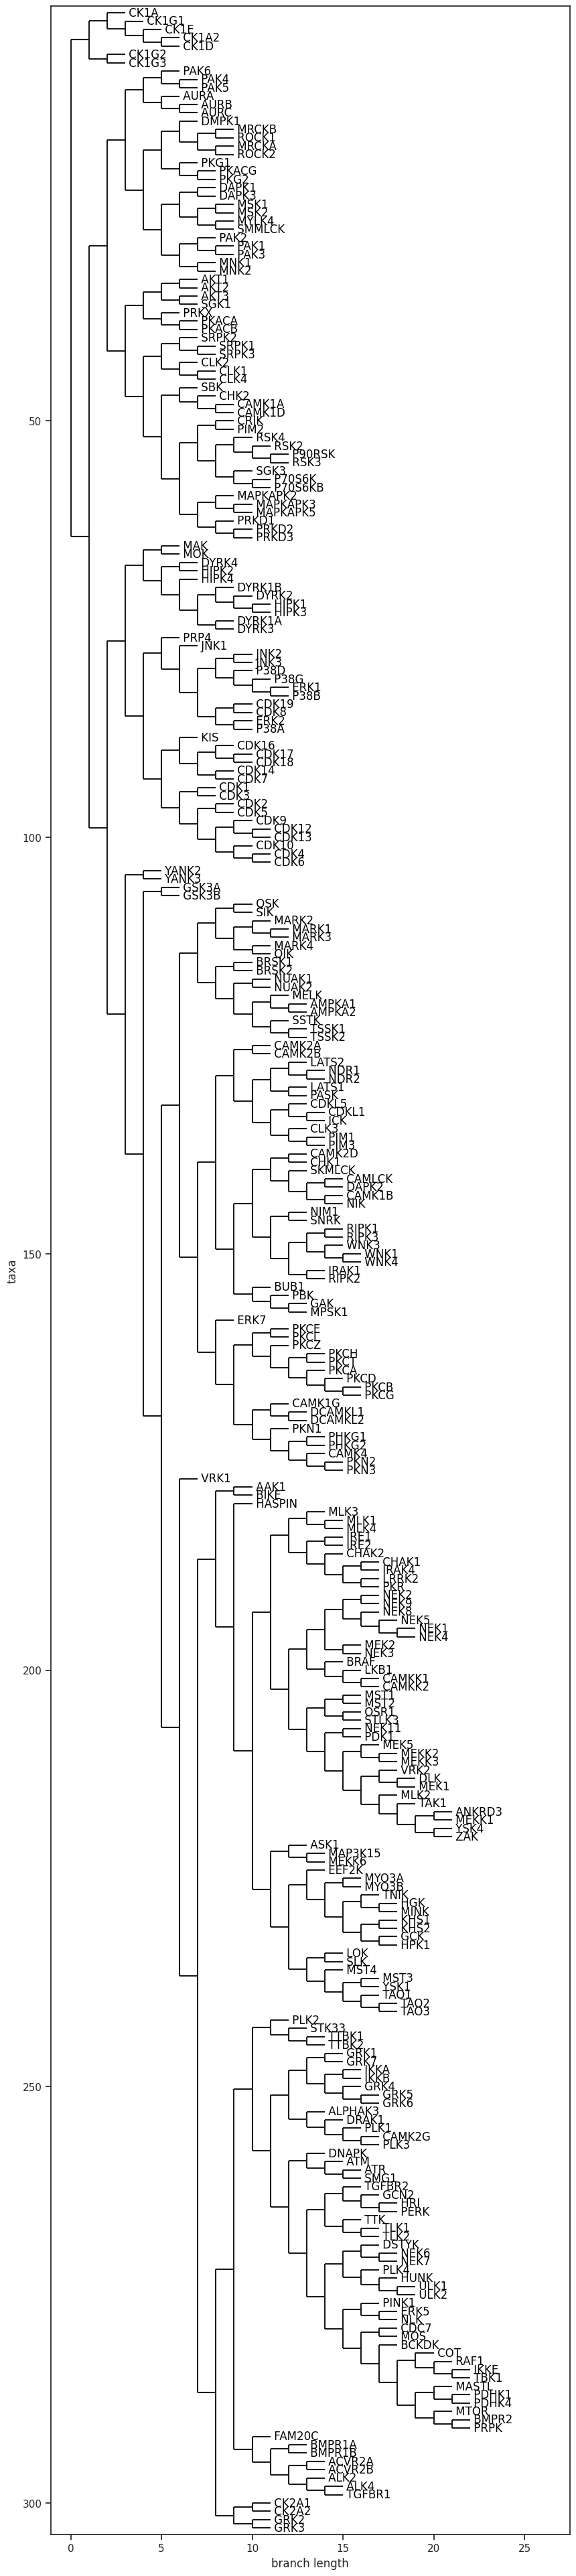

In [ ]:
linkage_matrix = get_linkage(q85,plot=True) # index is kinase

Normalized data from paper

In [ ]:
# linkage_matrix_norm = get_linkage(norm,plot=True)

## Plot tree clusters

We can cut the hierarchical clustering dendrogram at a certain distance to form flat clusters.

q is 0.99


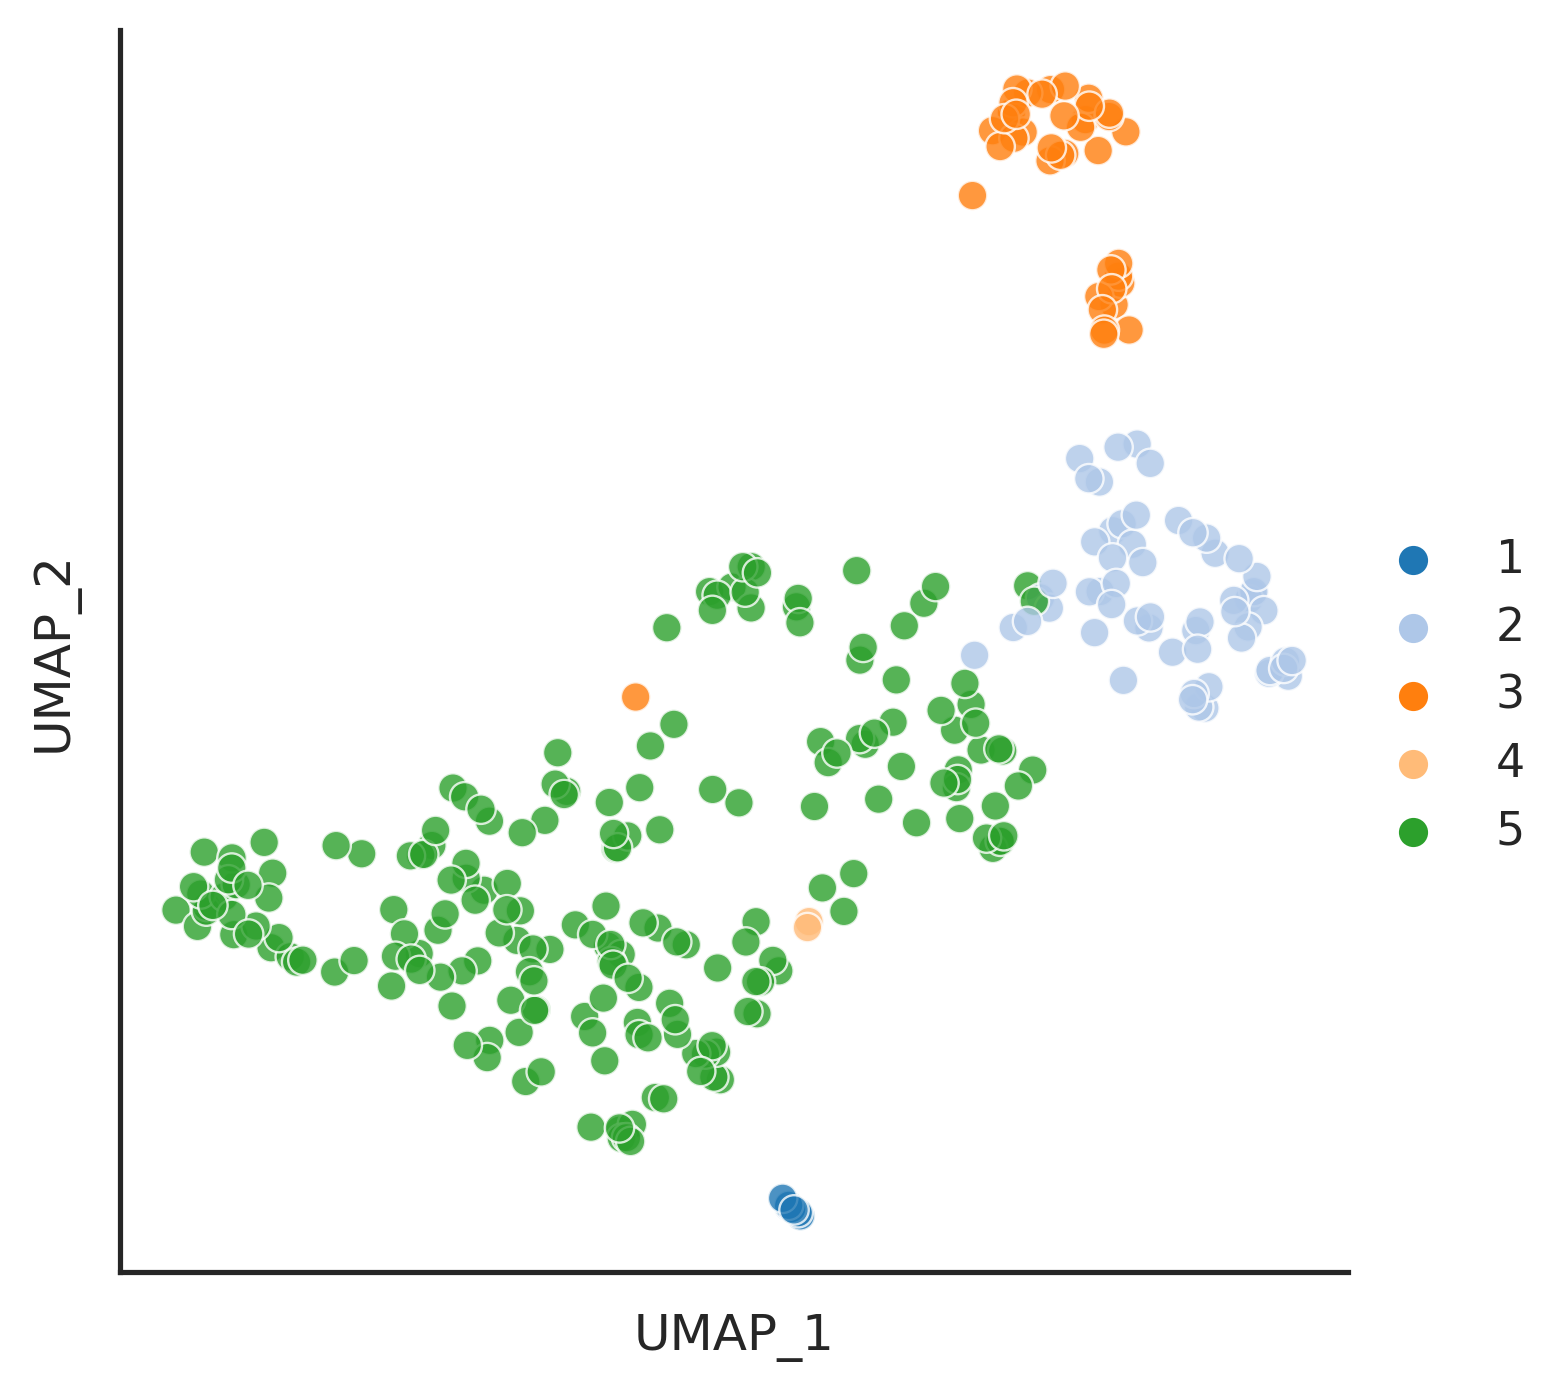

q is 0.95


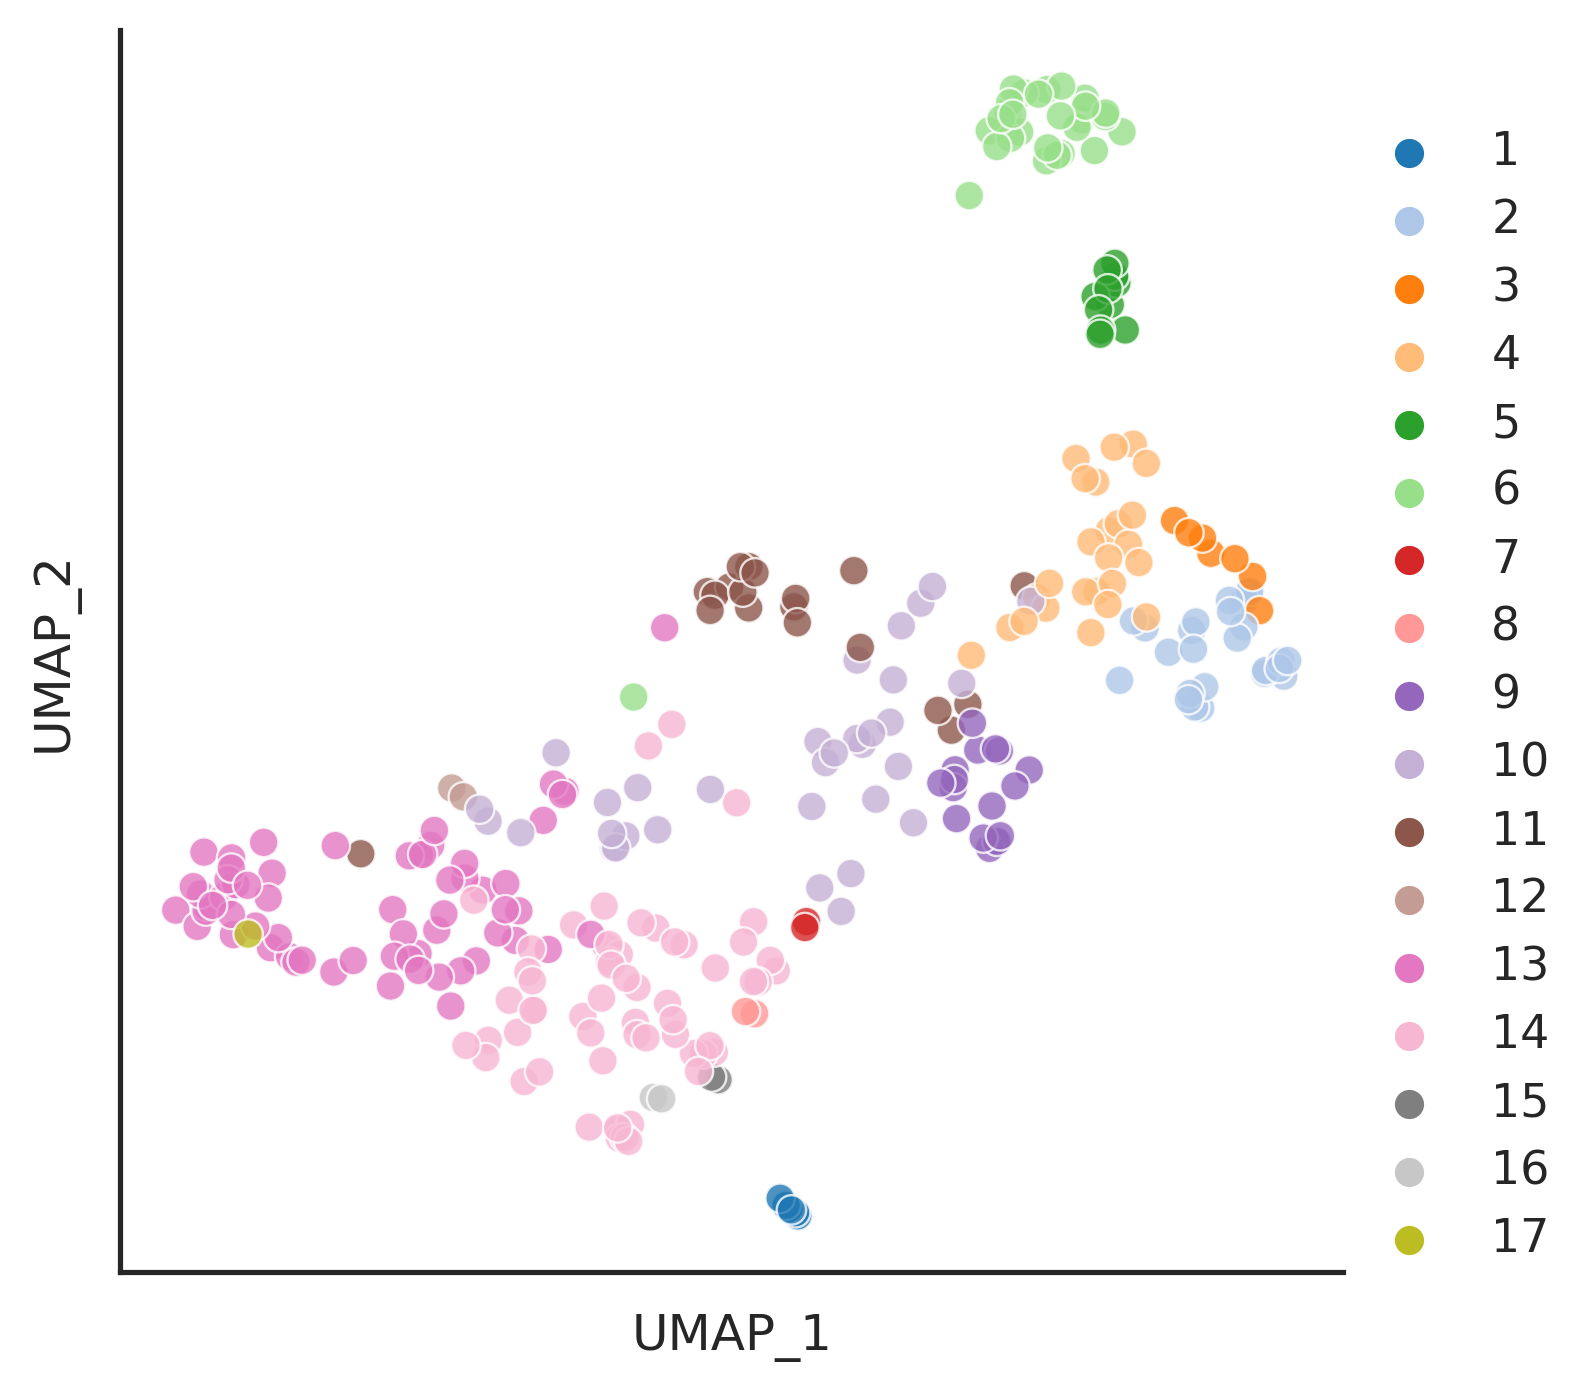

q is 0.9


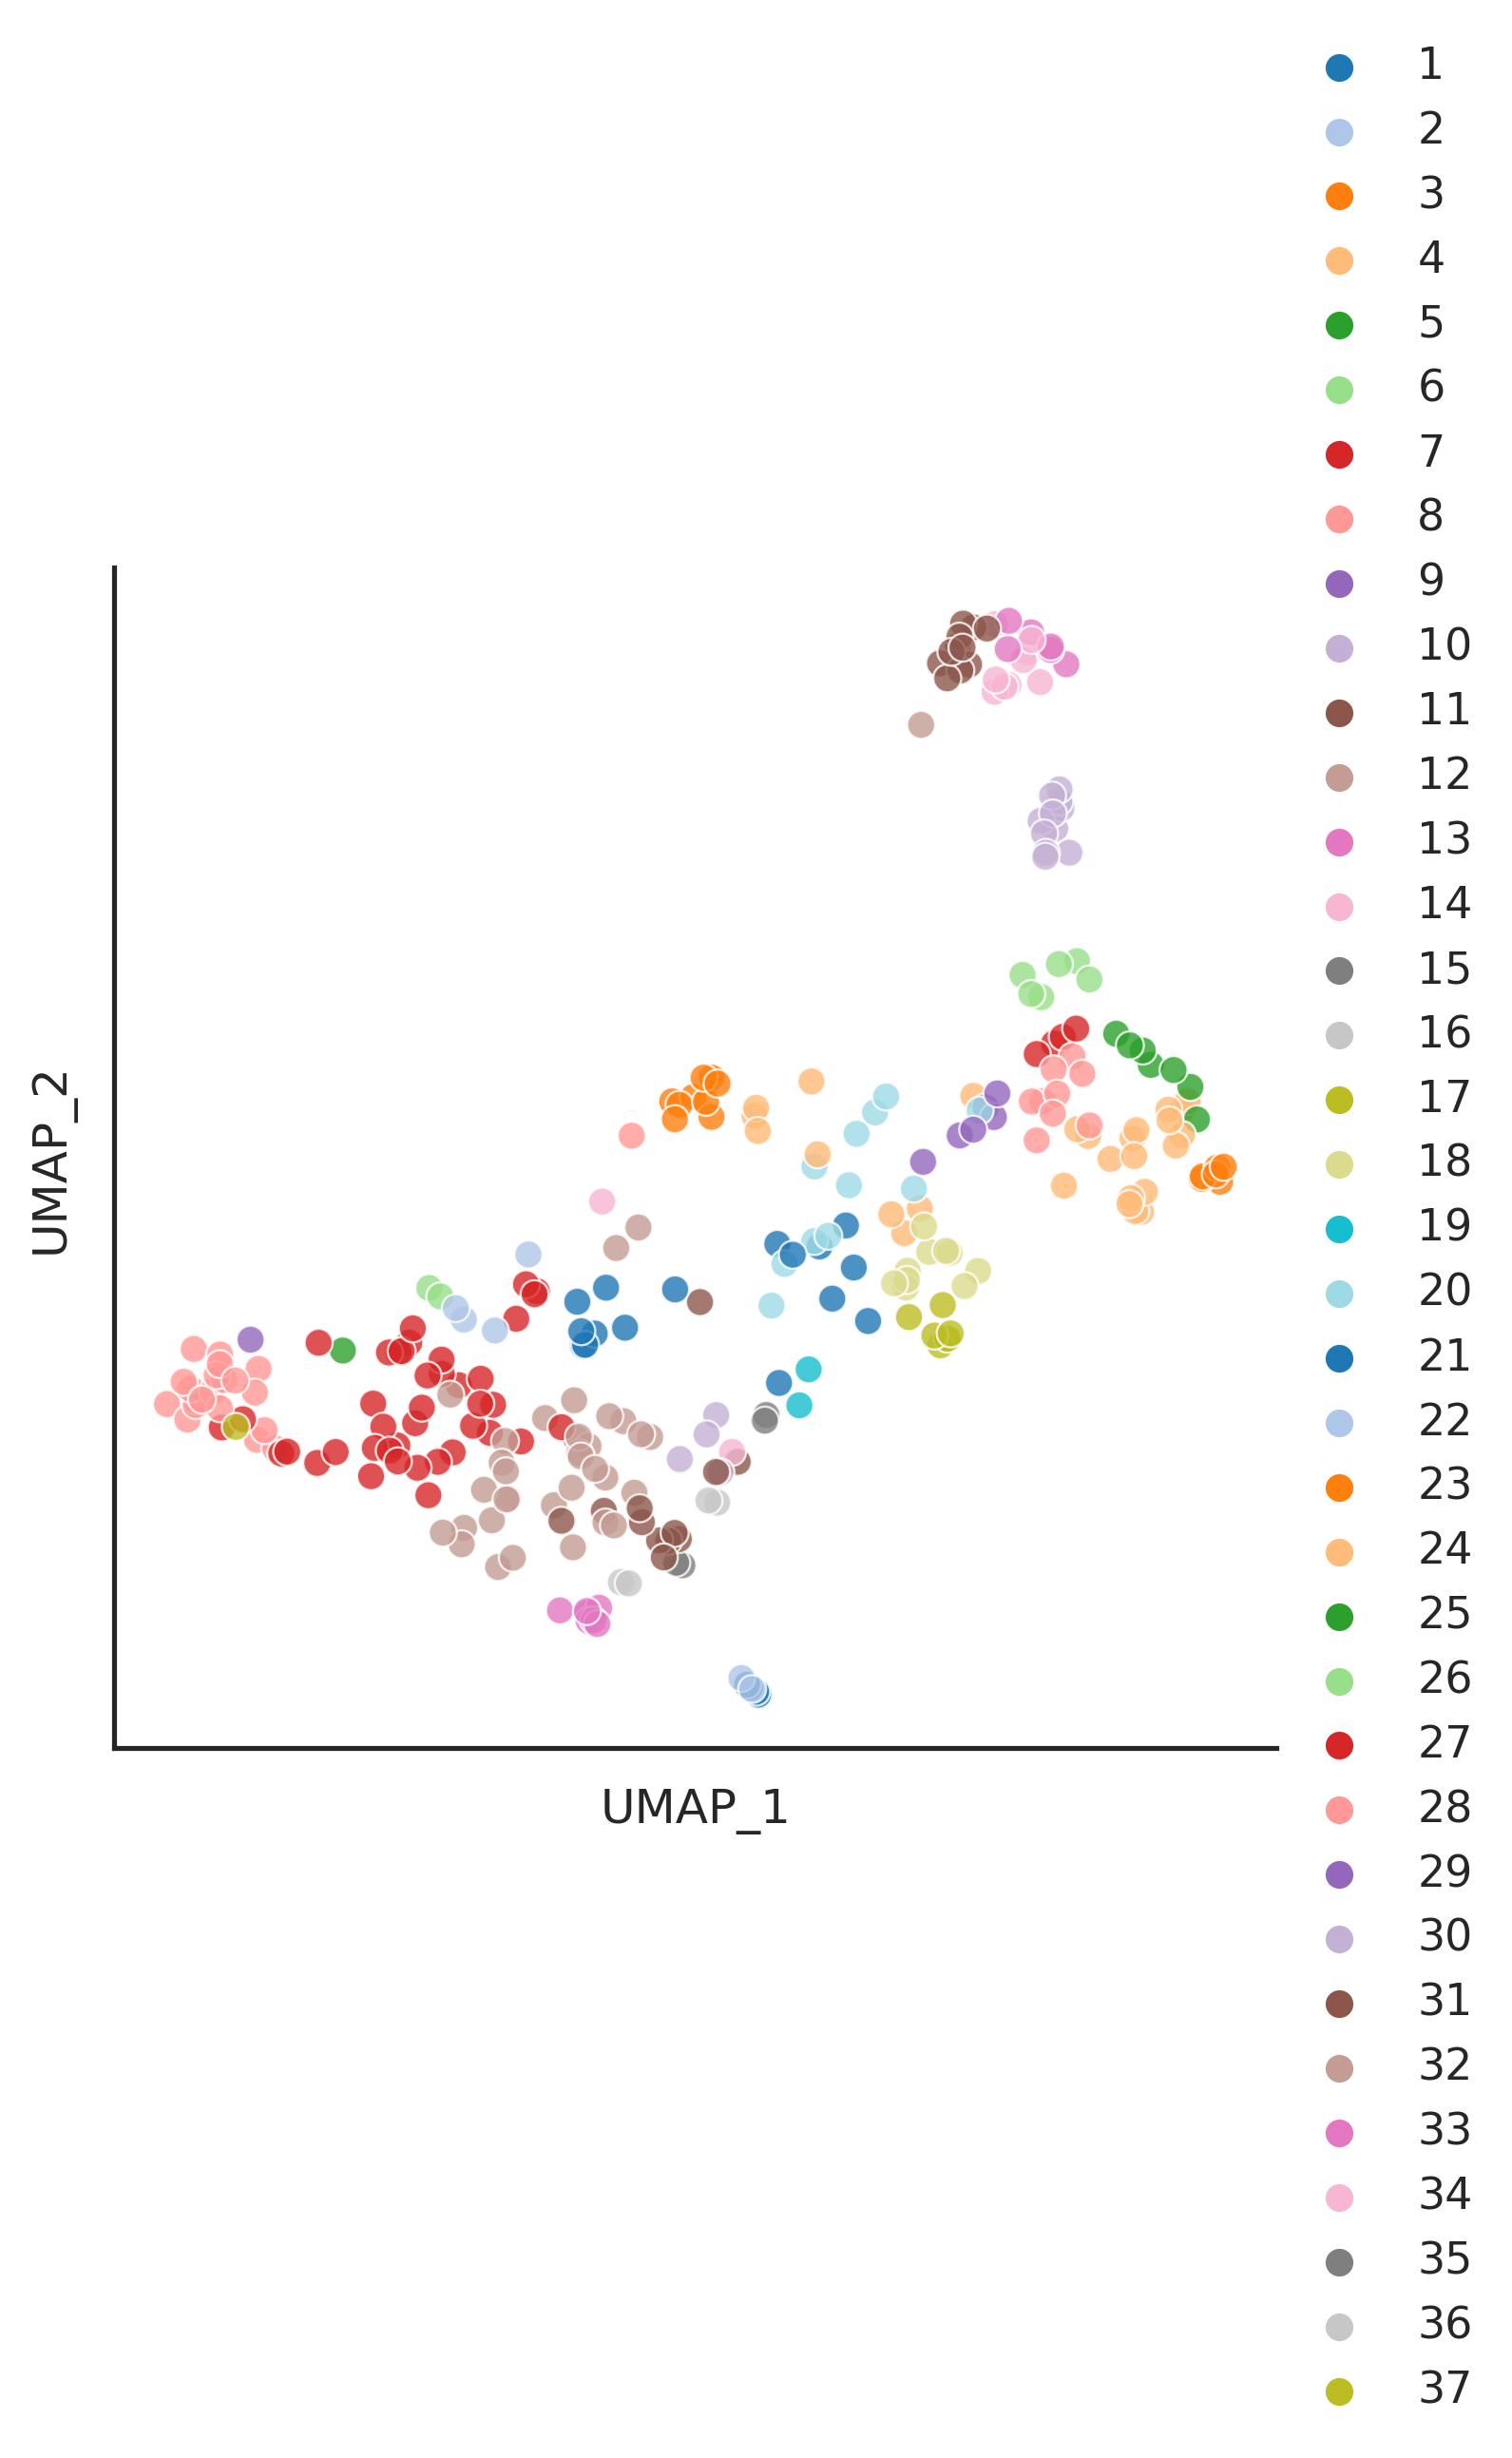

In [ ]:
for i in [0.99,0.95,0.9]:
    print(f'q is {i}') # lower value of q, more clusters
    cluster = get_hcluster(linkage_matrix, q = i)
    plot_cluster(q85, hue = cluster, legend=True,method= 'umap',complexity = 25)

## Plot with kinase info

In [ ]:
info = get_info(q85)

[  0 303]


In [ ]:
# info = Data.get_kinase_info_full()

# info = q85.reset_index()[['kinase']].merge(info,'left')

# (q85.reset_index().kinase == info.kinase).value_counts()

In [ ]:
info.columns

Index(['ID_coral', 'uniprot', 'ID_HGNC', 'group', 'family', 'subfamily_coral',
       'subfamily', 'in_paper', 'pseudo', 'species_paper', 'uniprot_paper',
       'range', 'human_uniprot_sequence', 'full_sequence_paper', 'sequence',
       'category', 'category_big', 'cluster', 'length', 'kinasecom_domain',
       'hdbscan'],
      dtype='object')

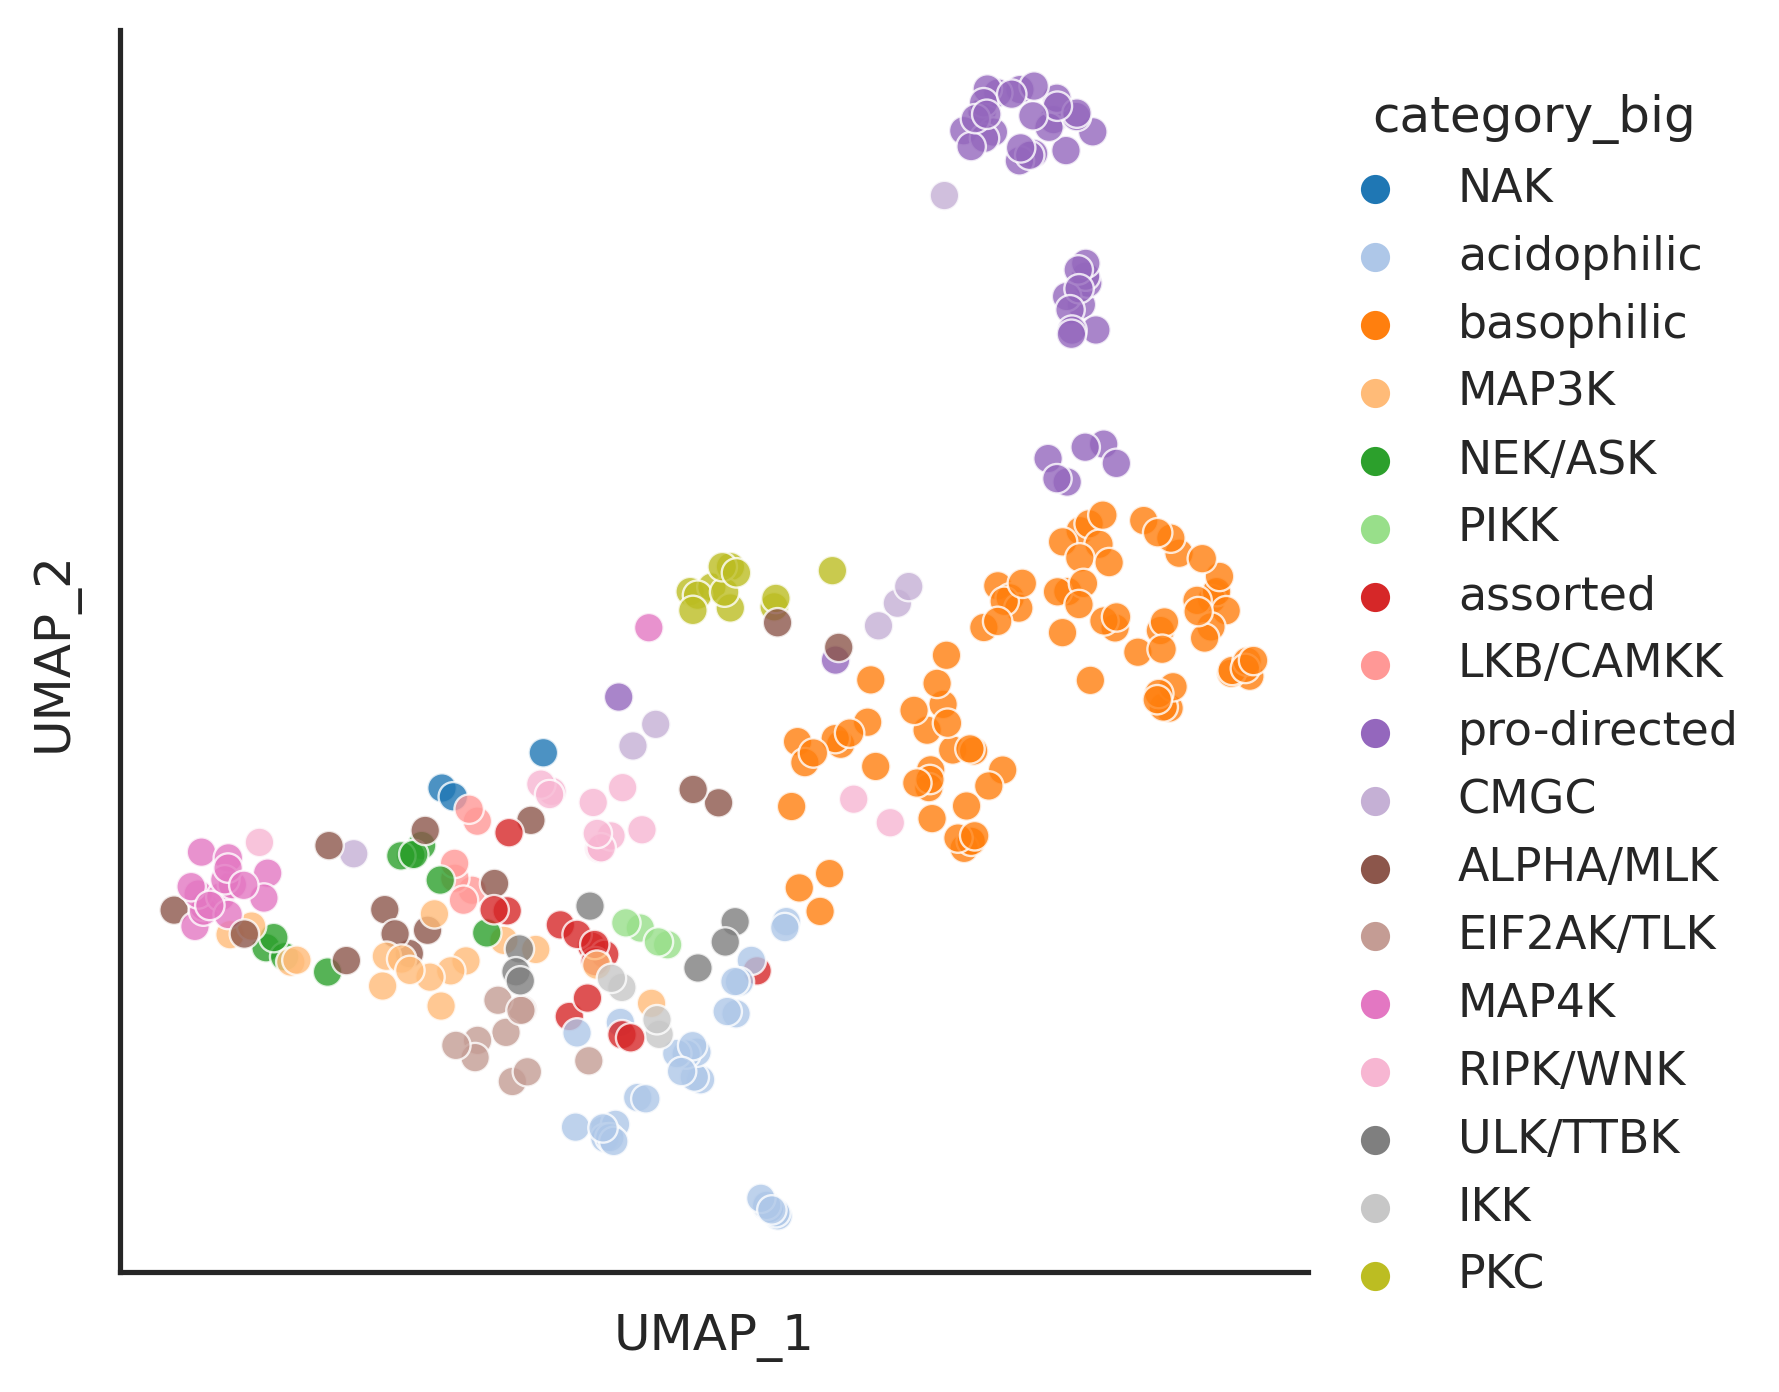

In [ ]:
plot_cluster(q85, hue = info.category_big, legend=True,method= 'umap', complexity = 25)

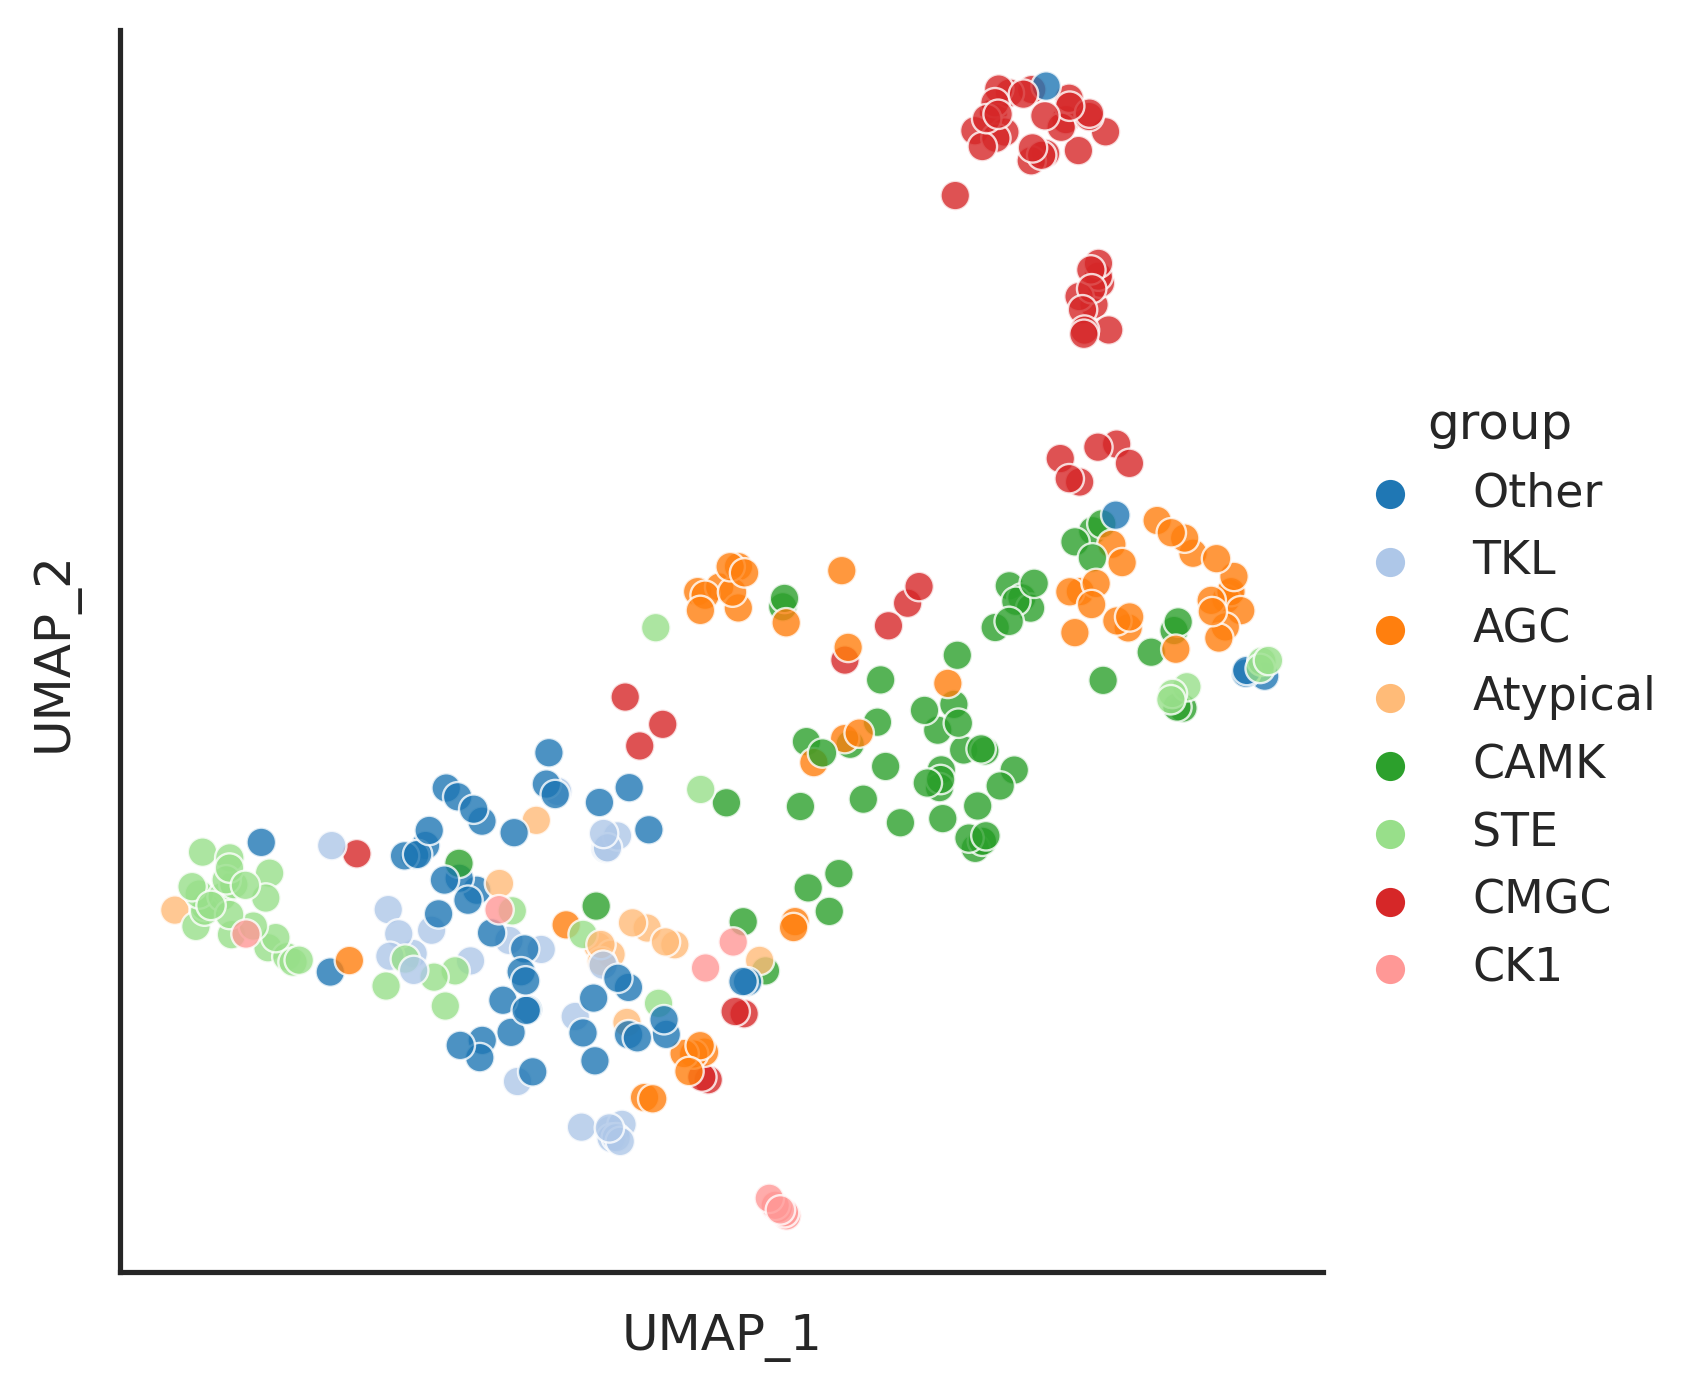

In [ ]:
plot_cluster(q85, hue = info.group, legend=True,method= 'umap', complexity = 25)

## Other clustering method

### Kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
def get_kcluster(df, # df with kinase as index
                 n = 10, # number of cluster
                 plot = False, # plot the WCSS
                normalize=False):
    
    if normalize:
        # Normalize the data
        scaler = StandardScaler()
        df = scaler.fit_transform(df)
    
    # Compute within-cluster sum-of-squares for different values of K
    if plot:
        wcss = []
        for i in range(1, 20):
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            kmeans.fit(df)
            wcss.append(kmeans.inertia_)

        # Plot the elbow graph
        plt.plot(range(1, 20), wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
    
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(df)
    
    return pred_y

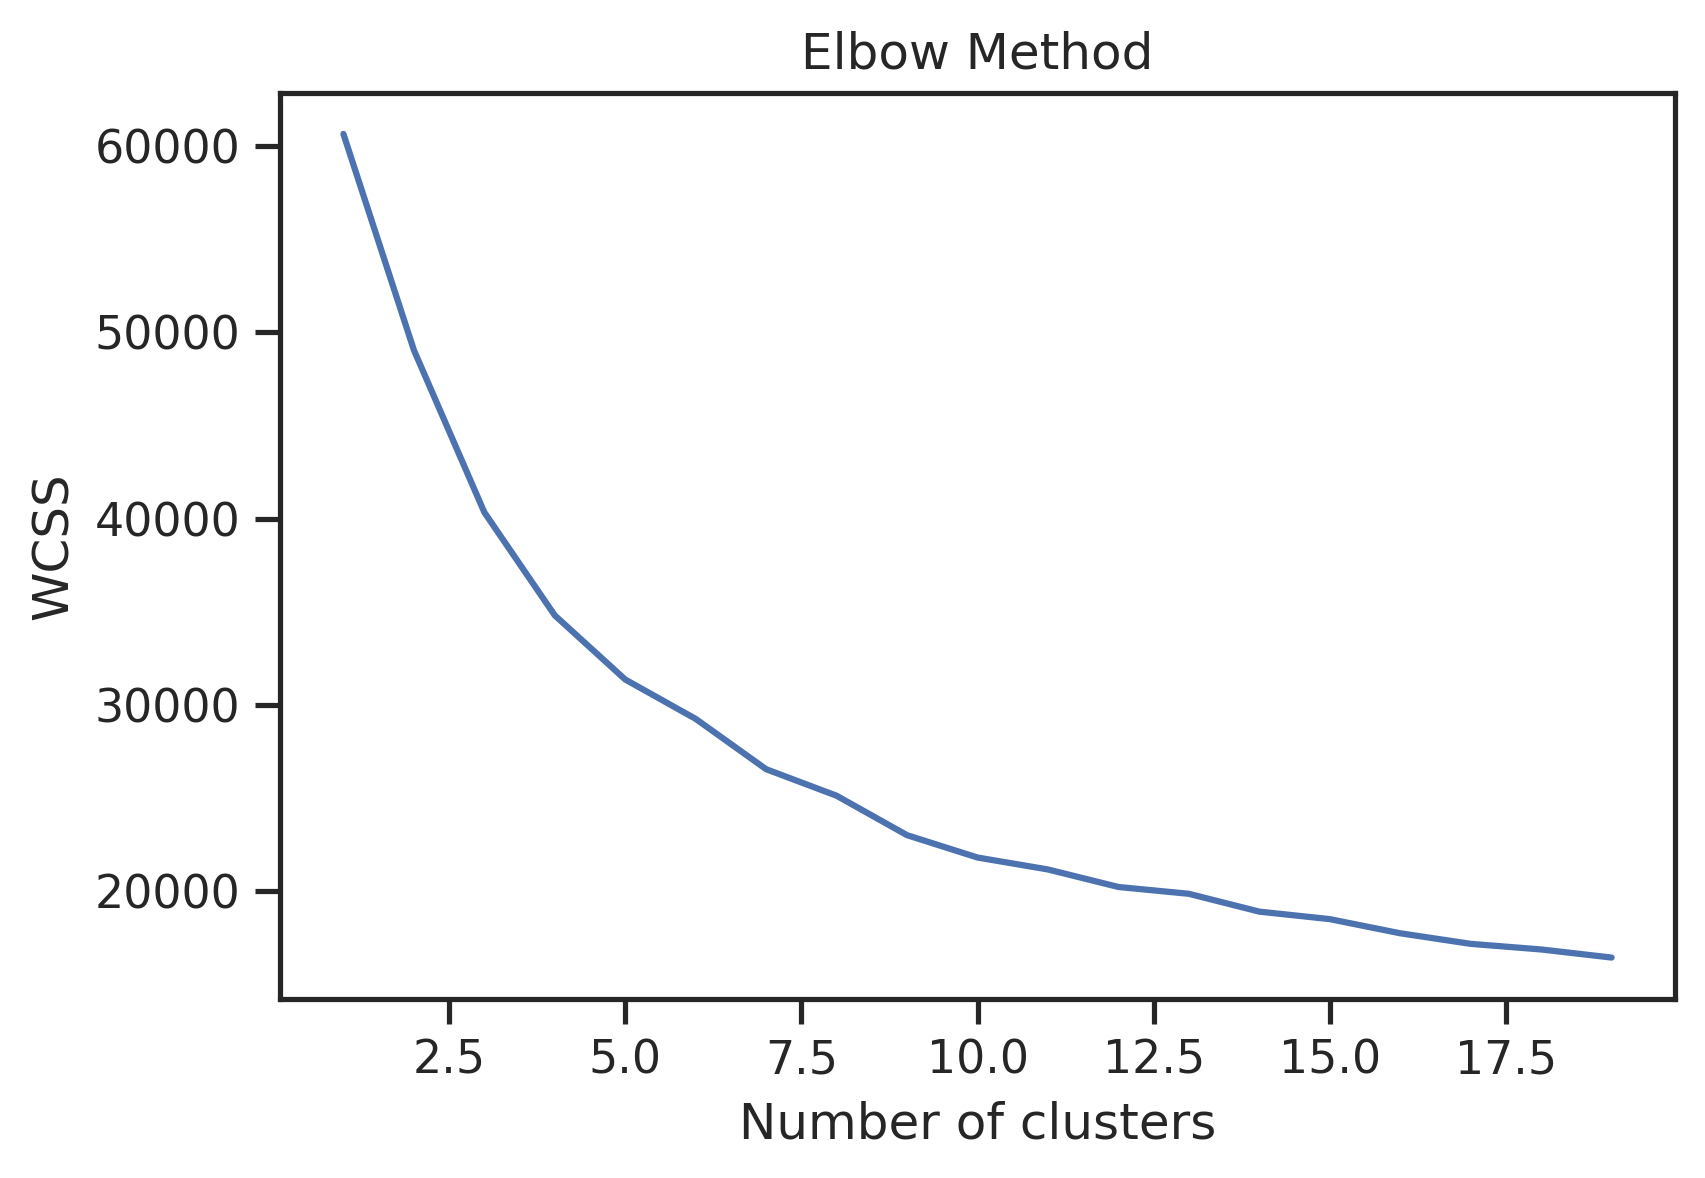

array([1, 0, 0, 5, 7, 7, 0, 0, 0, 4, 4, 1, 1, 0, 1, 5, 5, 5, 1, 1, 0, 0, 1, 1, 4, 4, 4, 7, 4, 7, 7, 0, 0, 4, 0, 4, 1, 1, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 7, 1, 1, 4, 7, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 7, 7, 4, 7, 1, 7, 5, 4, 5, 4, 4, 1, 5, 1, 1, 1, 7, 3, 3, 7, 3, 1, 3, 3, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 6, 6, 1, 1, 3, 3, 3, 4, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 1, 1, 3, 4, 4, 1, 1, 1, 7, 1, 7, 4, 7, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 7, 0, 1, 5, 5, 5, 5, 1, 1, 1, 1, 1, 5, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 4, 4, 1, 3, 3, 3, 3, 7, 4, 7, 4, 4, 4, 5, 5, 5, 0, 1, 1, 1, 1, 1, 4, 4, 7, 7, 4, 1, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 7, 4, 4, 1, 0, 0, 0, 1, 4, 7, 7, 5, 1, 1, 4, 4, 1, 1, 1, 1,
       5, 5, 7, 7, 7, 7, 7, 5, 4, 4, 1, 1, 4, 4, 7, 7, 7, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 4, 0, 1, 1, 1, 1, 9, 1, 4, 1, 1, 8, 8, 1, 1, 1], dtype=int32)

In [ ]:
get_kcluster(q85, plot=True, normalize=False)

kmeans clusters is 4


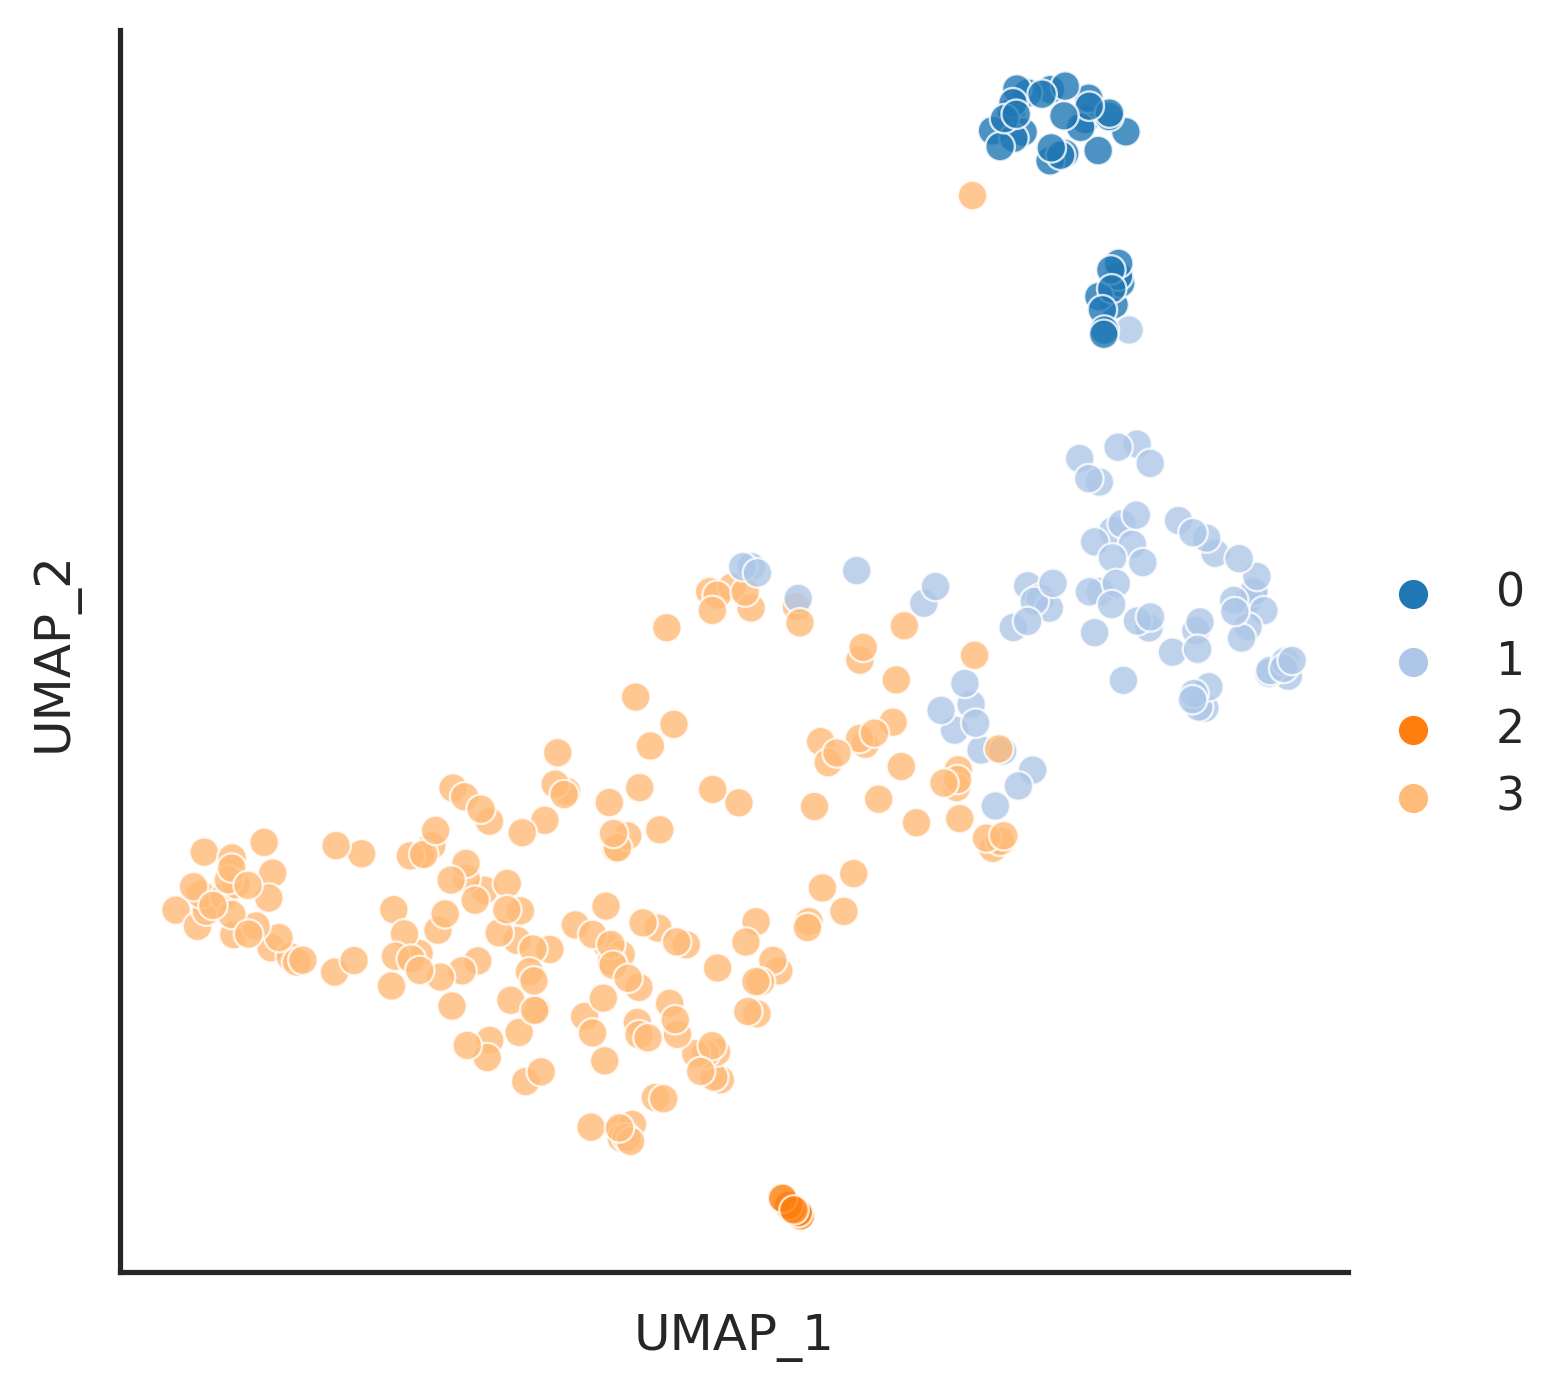

kmeans clusters is 6


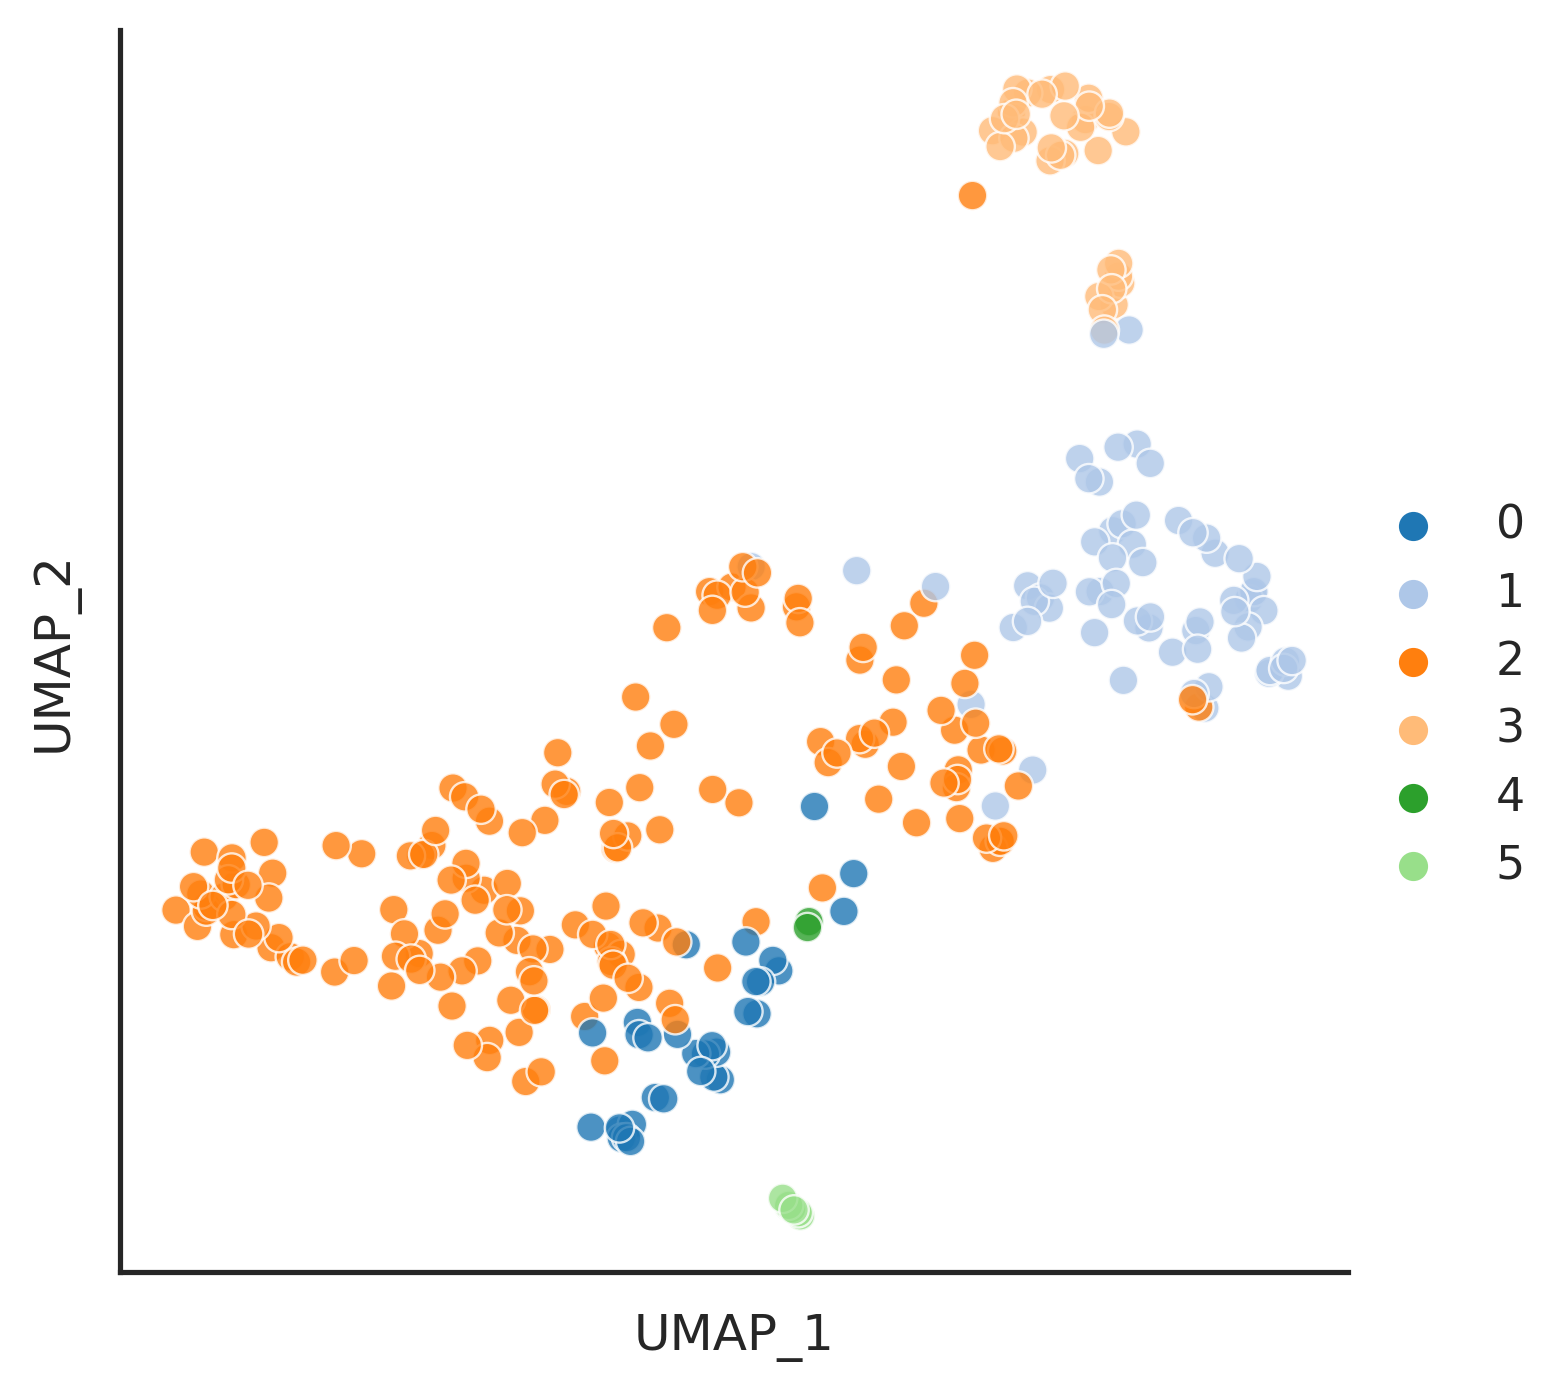

kmeans clusters is 8


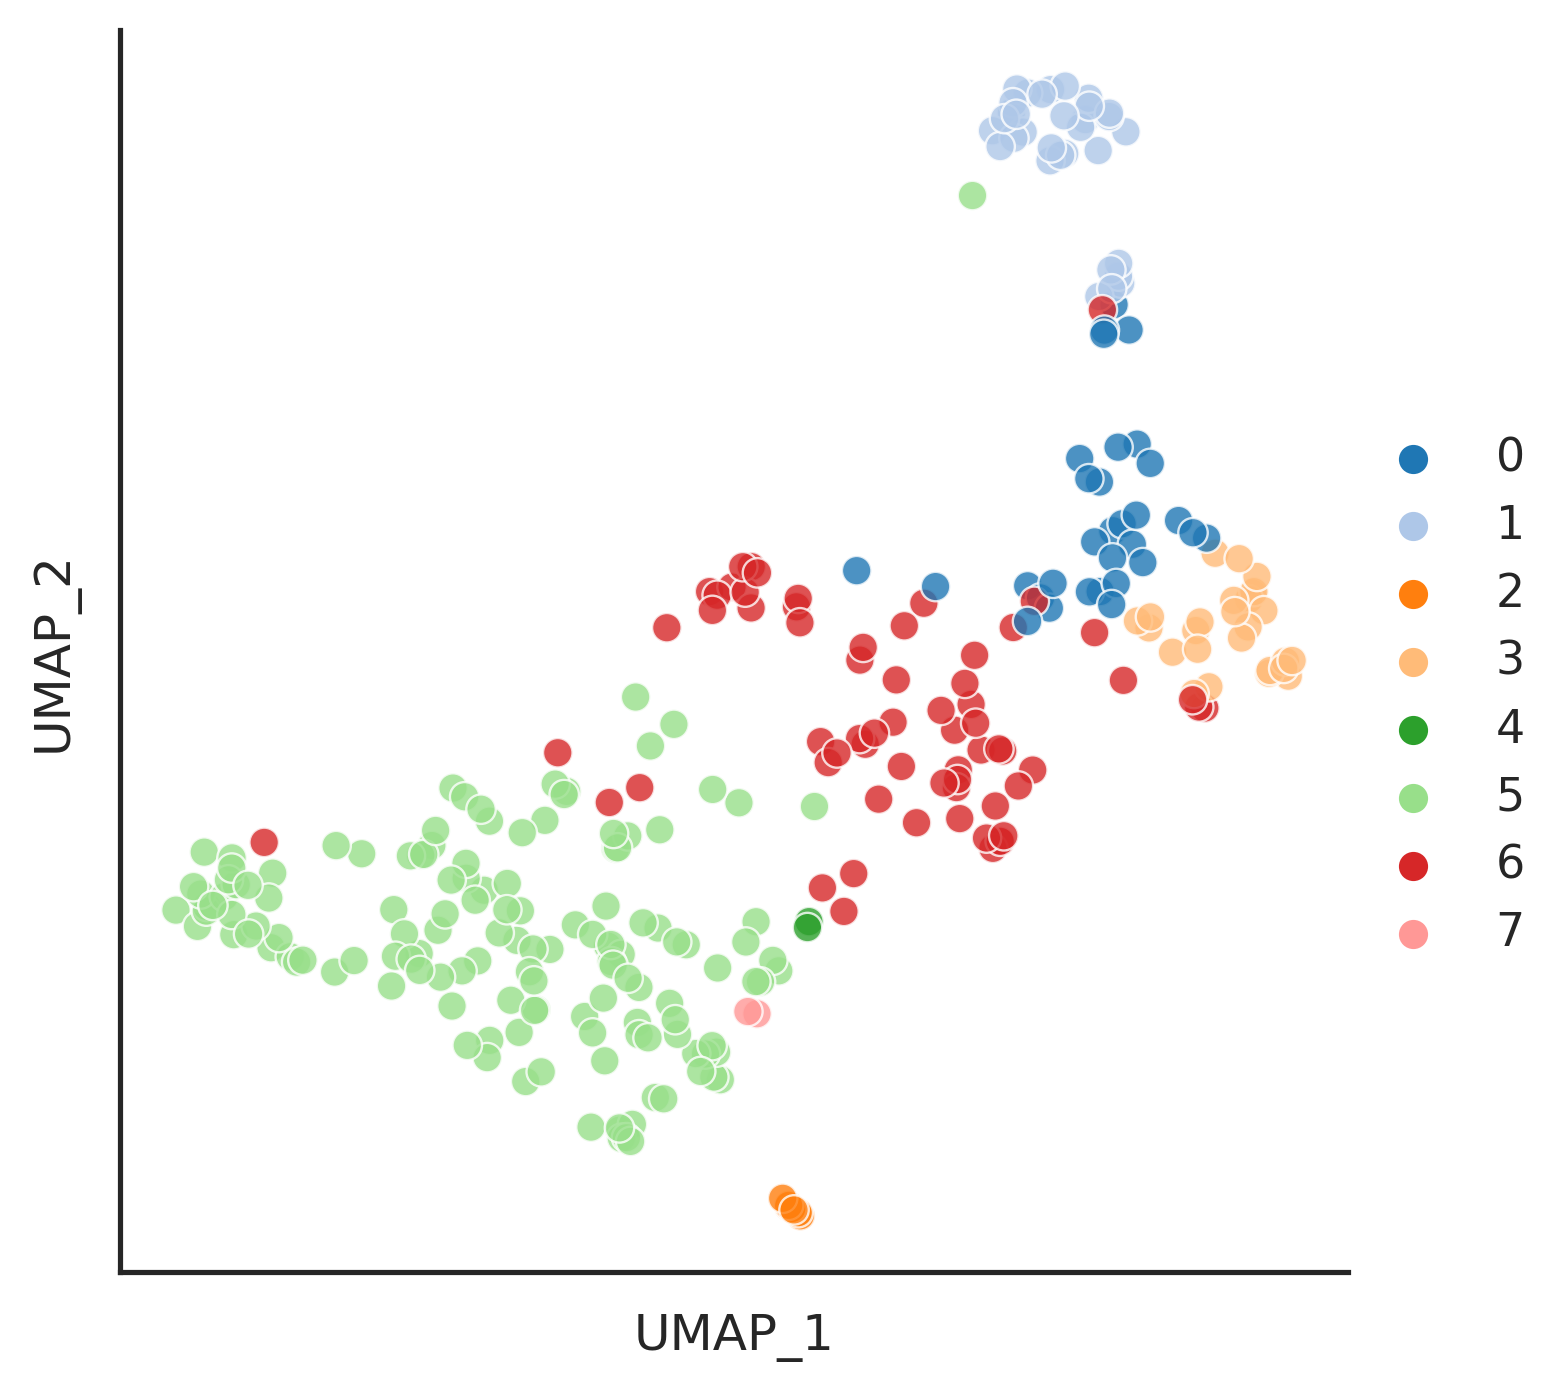

kmeans clusters is 10


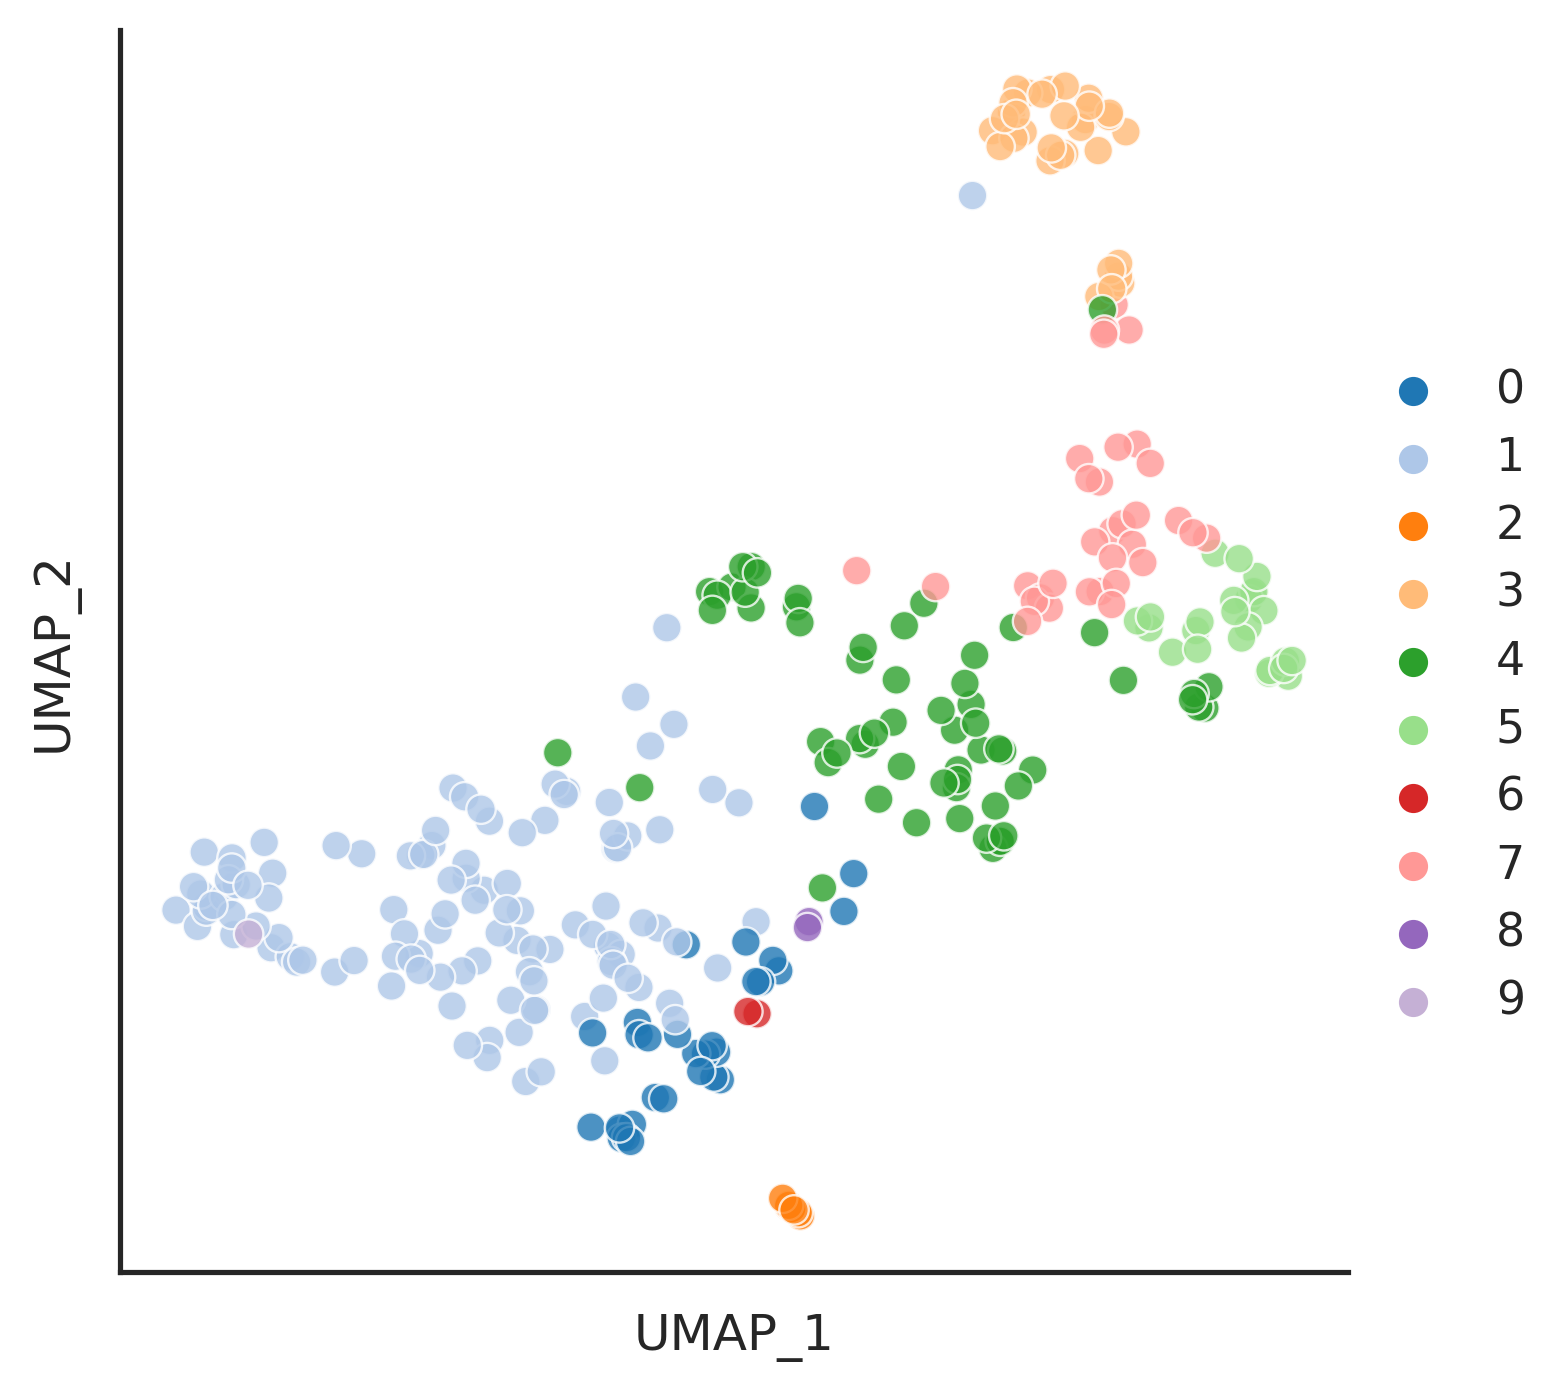

In [ ]:
for i in [4, 6, 8, 10]:
    print(f'kmeans clusters is {i}')
    cluster = get_kcluster(q85, n=i)
    plot_cluster(q85, hue = cluster, legend=True,method= 'umap', complexity = 25)

### HDBSCAN

In [ ]:
from sklearn.cluster import HDBSCAN

In [ ]:
def get_hdbscan(df, # kinase as index,
                        n,
                       ):
    embed = reduce_feature(df, method='umap', seed=123, complexity = 25)
    # embed = embeddings.set_index('kinase')
    
    clusterer = HDBSCAN(min_cluster_size = n) # or hdbscan.HDBSCAN if import hdbscan
    cluster = clusterer.fit_predict(embed)
    return cluster

hdbscan min cluster size is 5


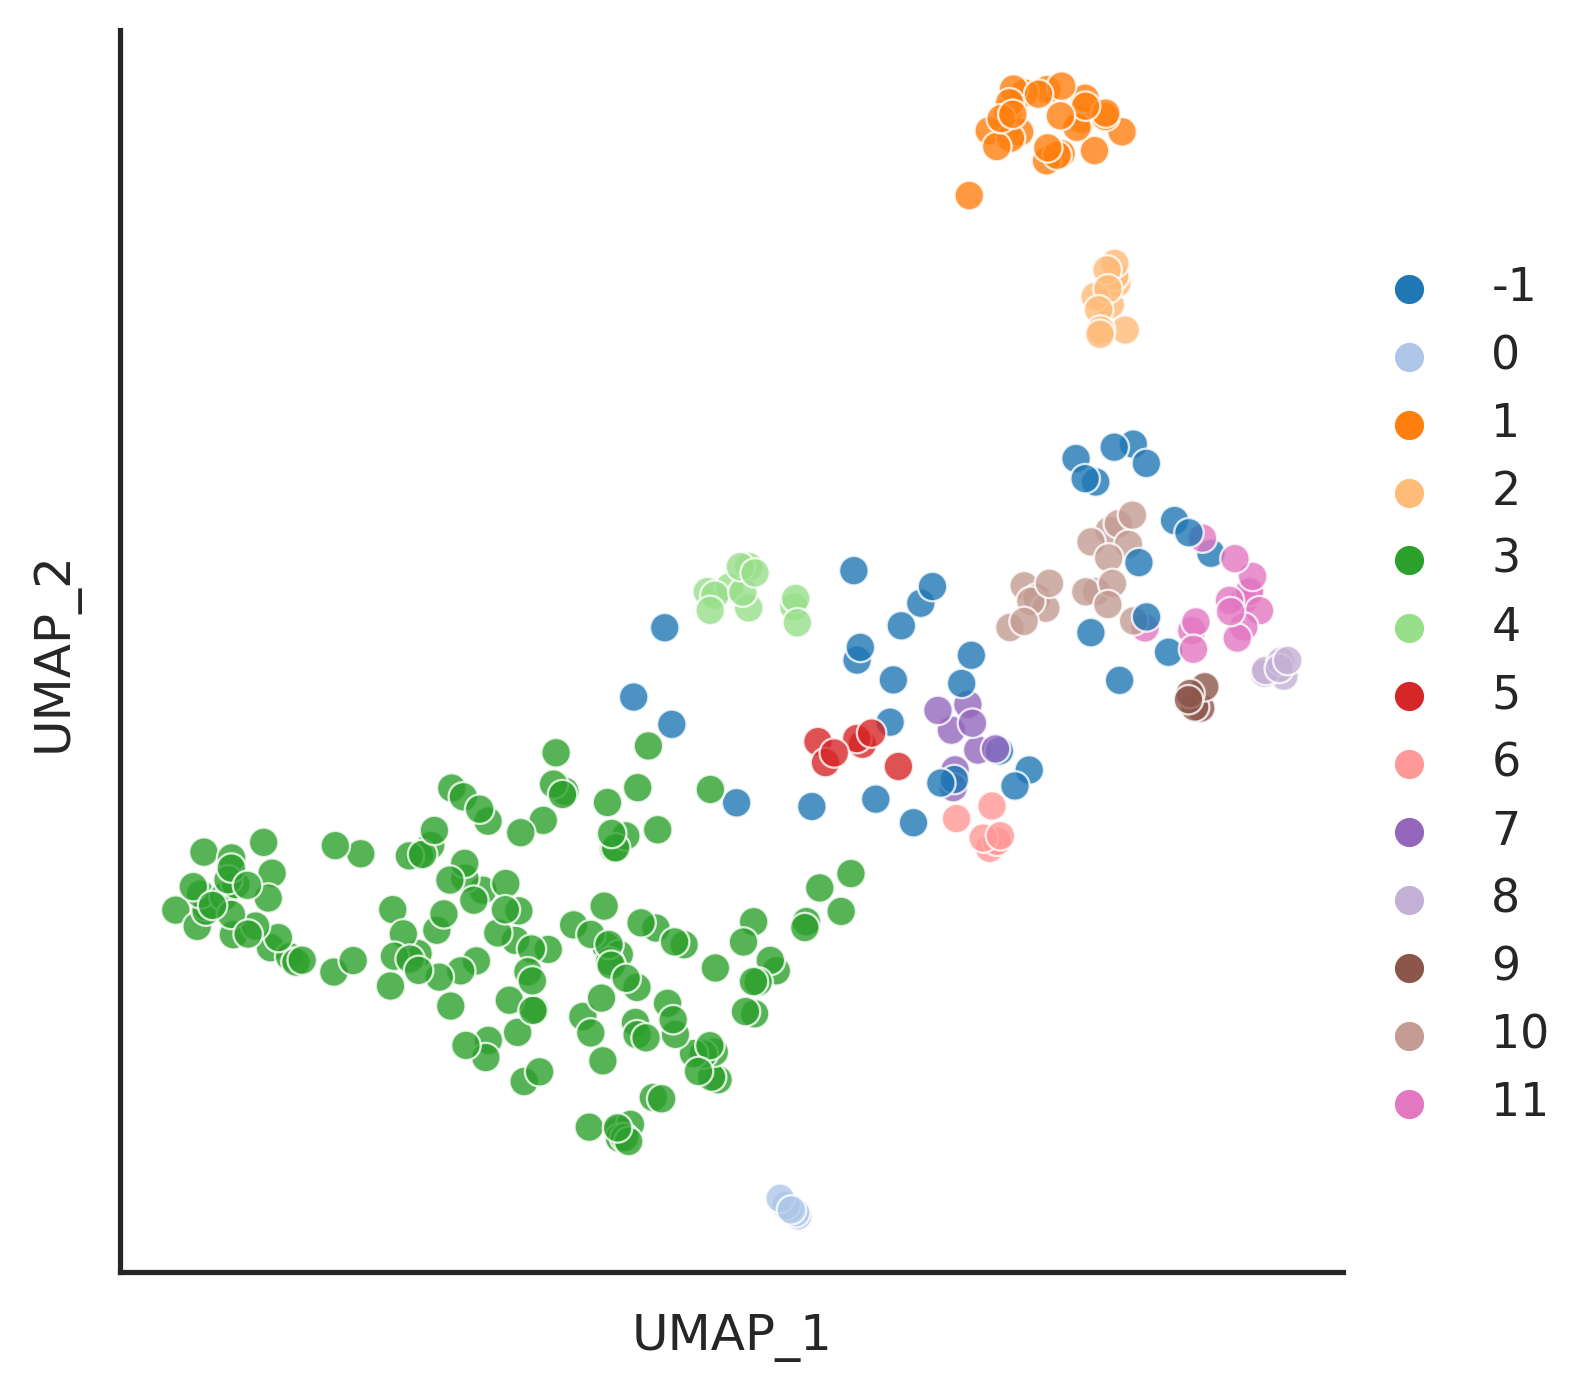

hdbscan min cluster size is 6


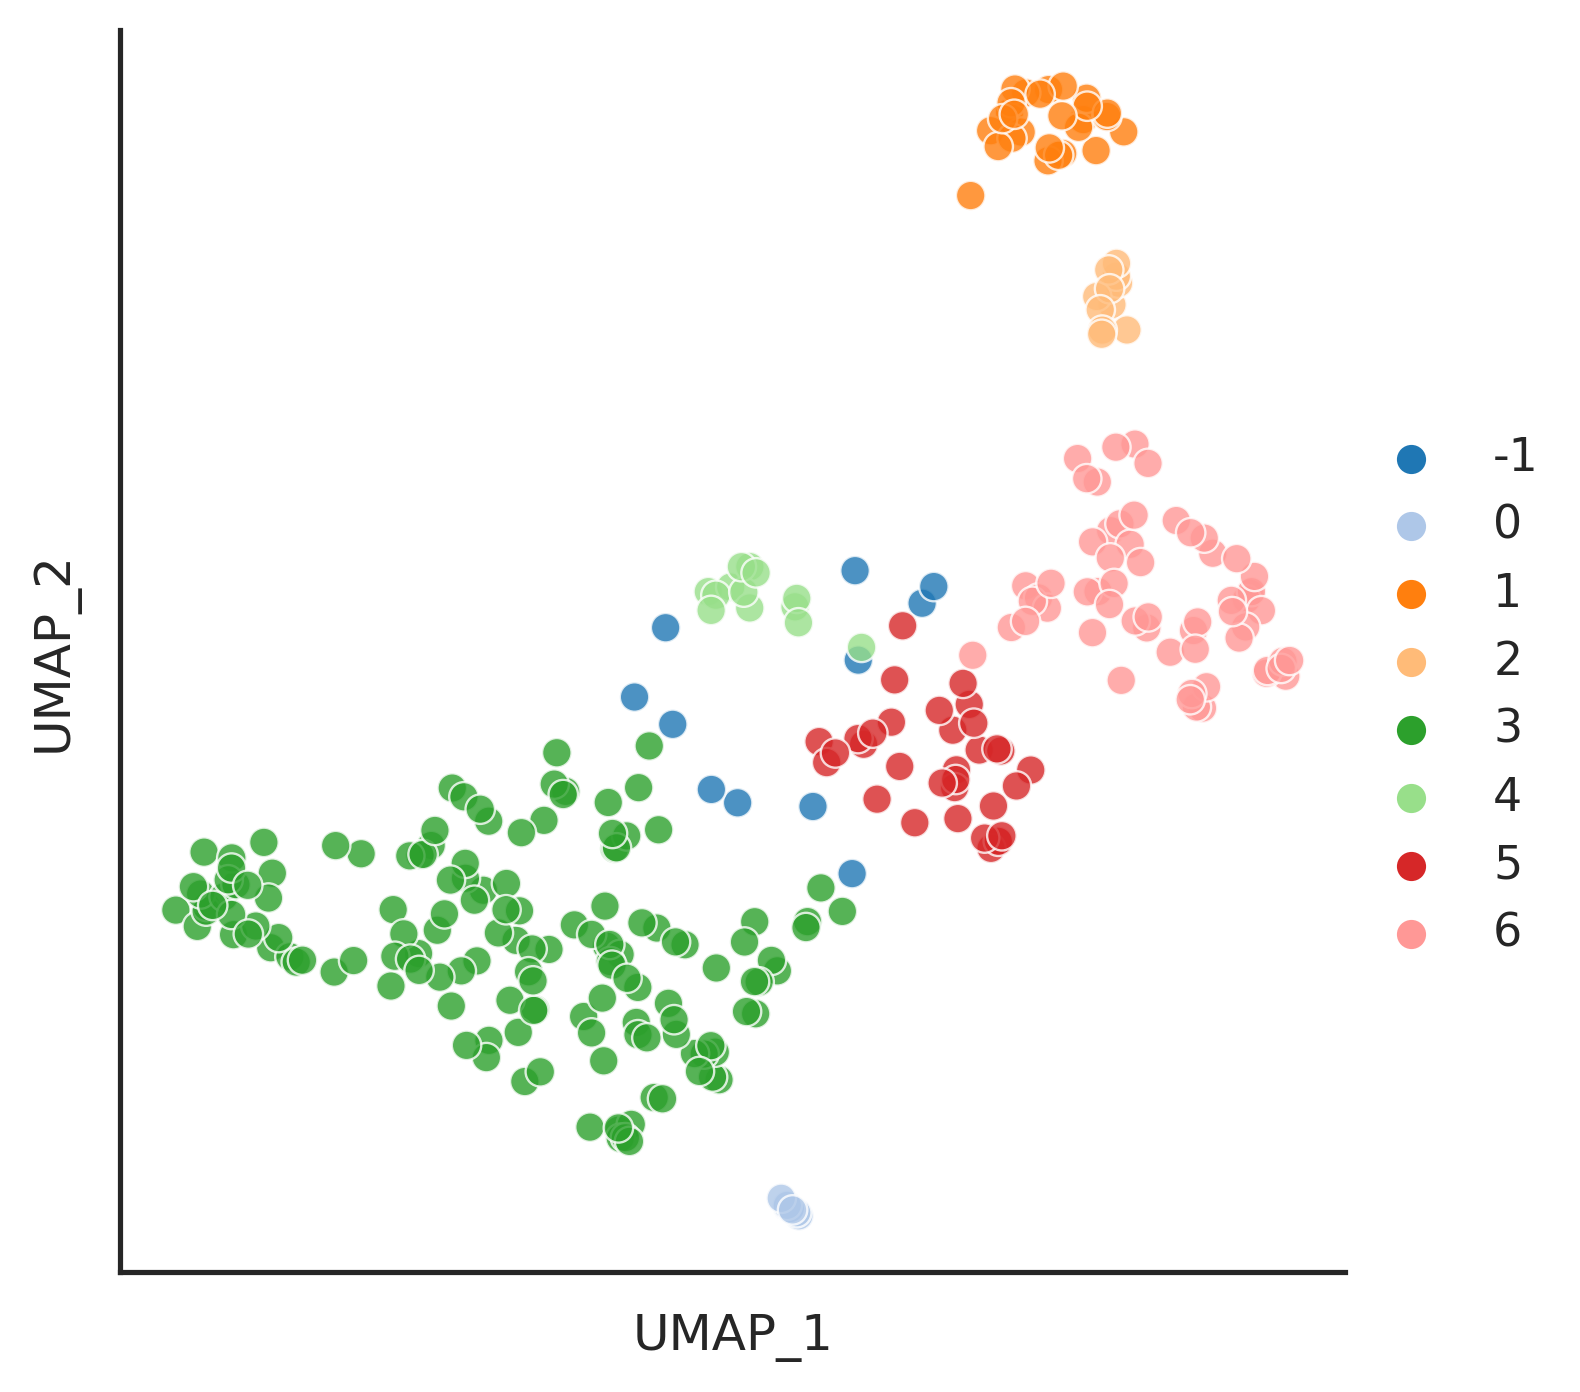

hdbscan min cluster size is 9


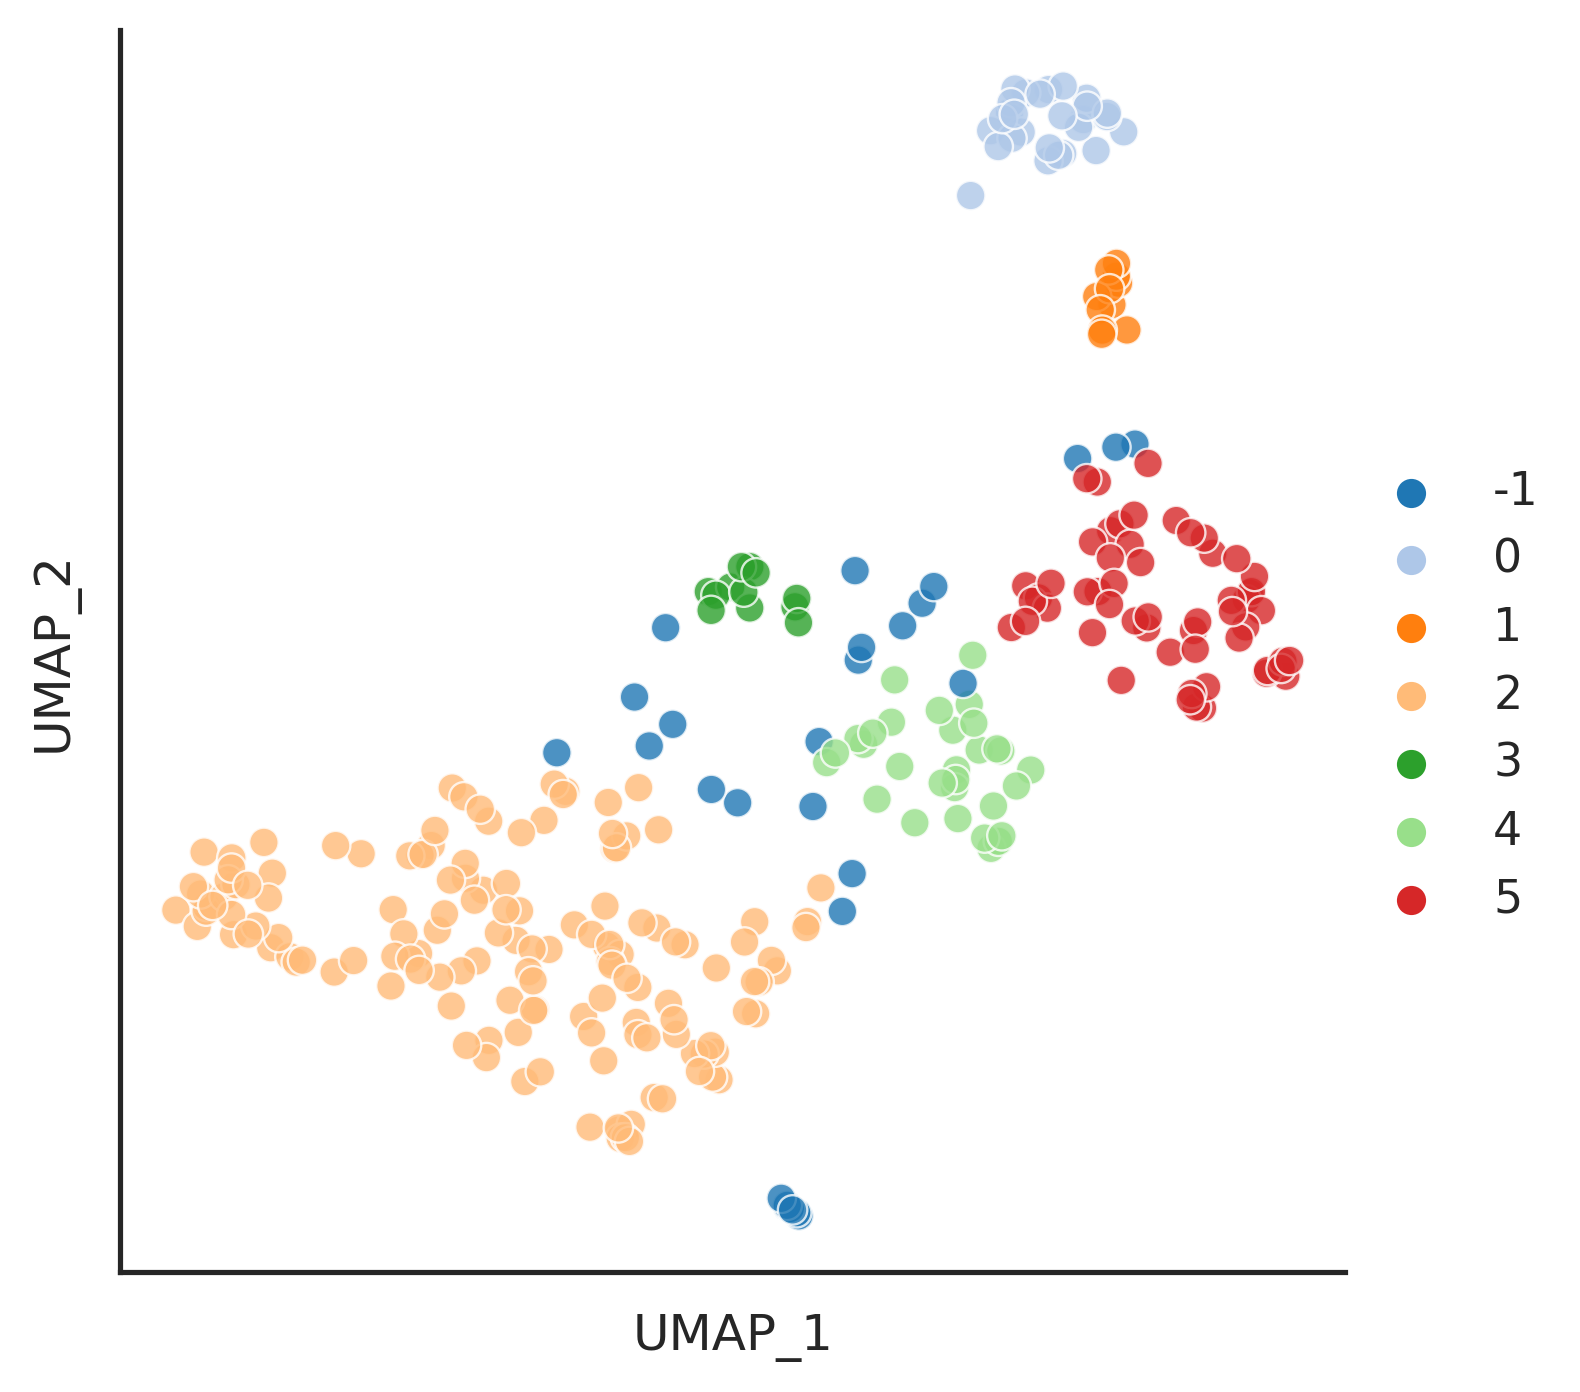

hdbscan min cluster size is 13


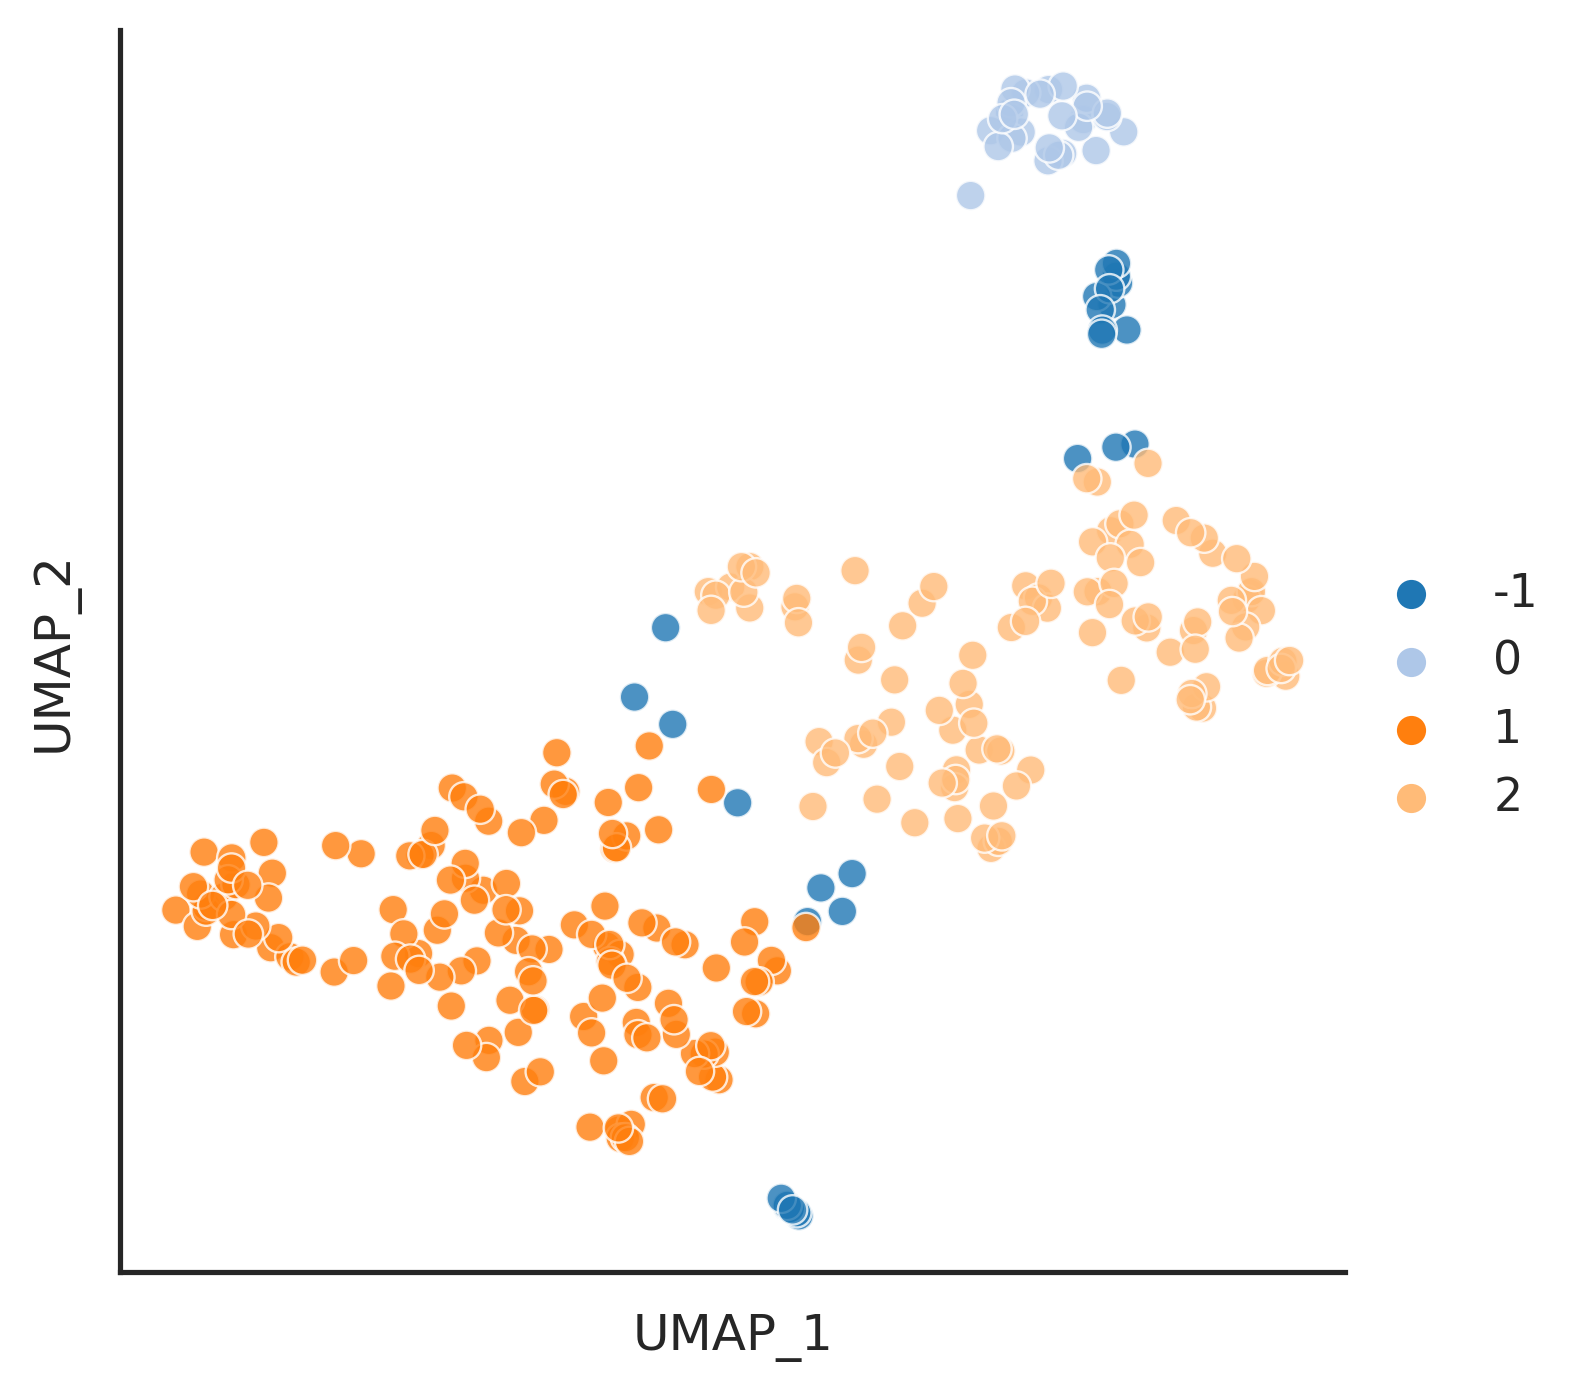

In [ ]:
for i in [5,6, 9, 13]:
    print(f'hdbscan min cluster size is {i}')
    cluster = get_hdbscan(q85, n=i)
    plot_cluster(q85, hue = cluster, legend=True,method= 'umap', complexity = 25)

Merge to current kinase info

In [ ]:
# cluster = get_hdbscan(q85, n=6)

# c = pd.DataFrame(cluster, index=q85.index, columns=['hdbscan']).reset_index()

# df = Data.get_kinase_info_full()

# df = df.merge(c,'left')

# df.to_parquet('../dataset/full_kinase_info.parquet')